# Import

In [1]:
import pandas as pd
import json
import wptools
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Setup

In [3]:
df = pd.read_json("data/cleaned_data.json", lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   verdict                    21152 non-null  object
 1   statement_originator       21152 non-null  object
 2   statement                  21152 non-null  object
 3   statement_date             21152 non-null  object
 4   statement_source           21152 non-null  object
 5   factchecker                21152 non-null  object
 6   factcheck_date             21152 non-null  object
 7   factcheck_analysis_link    21152 non-null  object
 8   party_affiliation          21152 non-null  object
 9   party_affiliation_refined  21152 non-null  object
dtypes: object(10)
memory usage: 1.6+ MB


In [5]:
df.groupby("party_affiliation").count()

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,party_affiliation_refined
party_affiliation,,,,,,,,,
Democratic,4515,4515,4515,4515,4515,4515,4515,4515,4515
Independent,279,279,279,279,279,279,279,279,279
Republican,6417,6417,6417,6417,6417,6417,6417,6417,6417
n/a,9773,9773,9773,9773,9773,9773,9773,9773,9773
other,168,168,168,168,168,168,168,168,168


In [7]:
def get_clean_party_affiliation(name):
    if not name or name.strip() == "":
        return "n/a"

    try:
        page = wptools.page(name + " (politician)", silent=True)
        page.get_parse(show=False)
        infobox = page.data.get('infobox', {})
        raw_party = infobox.get('party')

        if not raw_party:
            return 'n/a'

        clean = re.sub(r'\[\[|\]\]|\{\{|\}\}', '', raw_party)
        clean = clean.lower()

        if 'republican' in clean:
            return 'Republican'
        elif 'democratic' in clean:
            return 'Democratic'
        elif 'independent' in clean:
            return 'Independent'
        else:
            return 'other'

    except Exception as e:
        print(f"[ERROR] Failed on: '{name}' — {e}")
        return 'n/a'

def map_party_affiliations_conditional(statement_originator_series, current_affiliations, sleep=1.0):
    updated_affiliations = current_affiliations.copy()
    seen = {}

    for idx, (name, current_aff) in enumerate(zip(statement_originator_series, current_affiliations)):
        if current_aff not in ['n/a', 'other']:
            continue

        if name in seen:
            updated_affiliations.iloc[idx] = seen[name]
        else:
            new_aff = get_clean_party_affiliation(name)
            seen[name] = new_aff
            updated_affiliations.iloc[idx] = new_aff
            time.sleep(sleep)

    return updated_affiliations

In [ ]:
df["party_affiliation_refined"] = map_party_affiliations_conditional(
    df['statement_originator'], 
    df['party_affiliation']
)

In [9]:
df.groupby("party_affiliation_refined").count()

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,party_affiliation
party_affiliation_refined,,,,,,,,,
Democratic,4689,4689,4689,4689,4689,4689,4689,4689,4689
Independent,279,279,279,279,279,279,279,279,279
Republican,6894,6894,6894,6894,6894,6894,6894,6894,6894
n/a,9275,9275,9275,9275,9275,9275,9275,9275,9275
other,15,15,15,15,15,15,15,15,15


In [13]:
#df.to_json("data/cleaned_data.json",orient='records', lines=True)

In [11]:
verdict_map = {
    'true': 1.0,
    'mostly-true': 0.75,
    'half-true': 0.5,
    'mostly-false': 0.25,
    'false': 0.0,
    'pants-fire': 0.0
}
df['verdict_score'] = df['verdict'].map(verdict_map)

In [13]:
df['statement_date'] = pd.to_datetime(df['statement_date'])
df['statement_year'] = df['statement_date'].dt.strftime('%Y')

# Analysis

In [15]:
# Republican vs Democratic
df = df[(df['party_affiliation_refined'] == 'Republican') | (df['party_affiliation_refined'] == 'Democratic')]
df

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,party_affiliation,party_affiliation_refined,verdict_score,statement_year
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,2008-06-11,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...,Democratic,Democratic,1.00,2008
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",2022-06-07,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...,Republican,Republican,0.00,2022
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",2016-05-18,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...,Republican,Republican,0.75,2016
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",2015-08-30,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...,Republican,Republican,0.50,2015
5,true,S.E. Cupp,"""There are actually only 30 countries that pra...",2015-08-23,news,Will Cabaniss,8/23/2015,https://www.politifact.com/factchecks/2015/aug...,Republican,Republican,1.00,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
21144,mostly-true,Rick Scott,"""Florida ranks first in the nation for access ...",2014-03-16,social_media,Amy Sherman,3/20/2014,https://www.politifact.com/factchecks/2014/mar...,Republican,Republican,0.75,2014
21145,false,Hillary Clinton,"""We now have driven (health care) costs down t...",2016-01-17,speech,C. Eugene Emery Jr.,1/18/2016,https://www.politifact.com/factchecks/2016/jan...,Democratic,Democratic,0.00,2016
21147,mostly-false,Donald Trump,Says the large trade deficit with Japan stems ...,2019-08-13,speech,Jon Greenberg,8/15/2019,https://www.politifact.com/factchecks/2019/aug...,Republican,Republican,0.25,2019
21148,false,Donald Trump Jr.,"""Tens of thousands"" of people leave New York e...",2019-11-01,social_media,Jill Terreri Ramos,11/8/2019,https://www.politifact.com/factchecks/2019/nov...,Republican,Republican,0.00,2019


## Party Analysis

In [17]:
df_party = df.groupby(['statement_year', 'party_affiliation_refined'])['verdict_score'].mean().reset_index()
df_party = df_party.rename(columns={'verdict_score': 'avg_verdict_score'})
df_party

,statement_year,party_affiliation_refined,avg_verdict_score
0,2002,Democratic,0.250000
1,2007,Democratic,0.428030
2,2007,Republican,0.432836
3,2008,Democratic,0.629581
4,2008,Republican,0.519817
5,2009,Democratic,0.501825
6,2009,Republican,0.383013
7,2010,Democratic,0.525275
8,2010,Republican,0.426215
9,2011,Democratic,0.546697


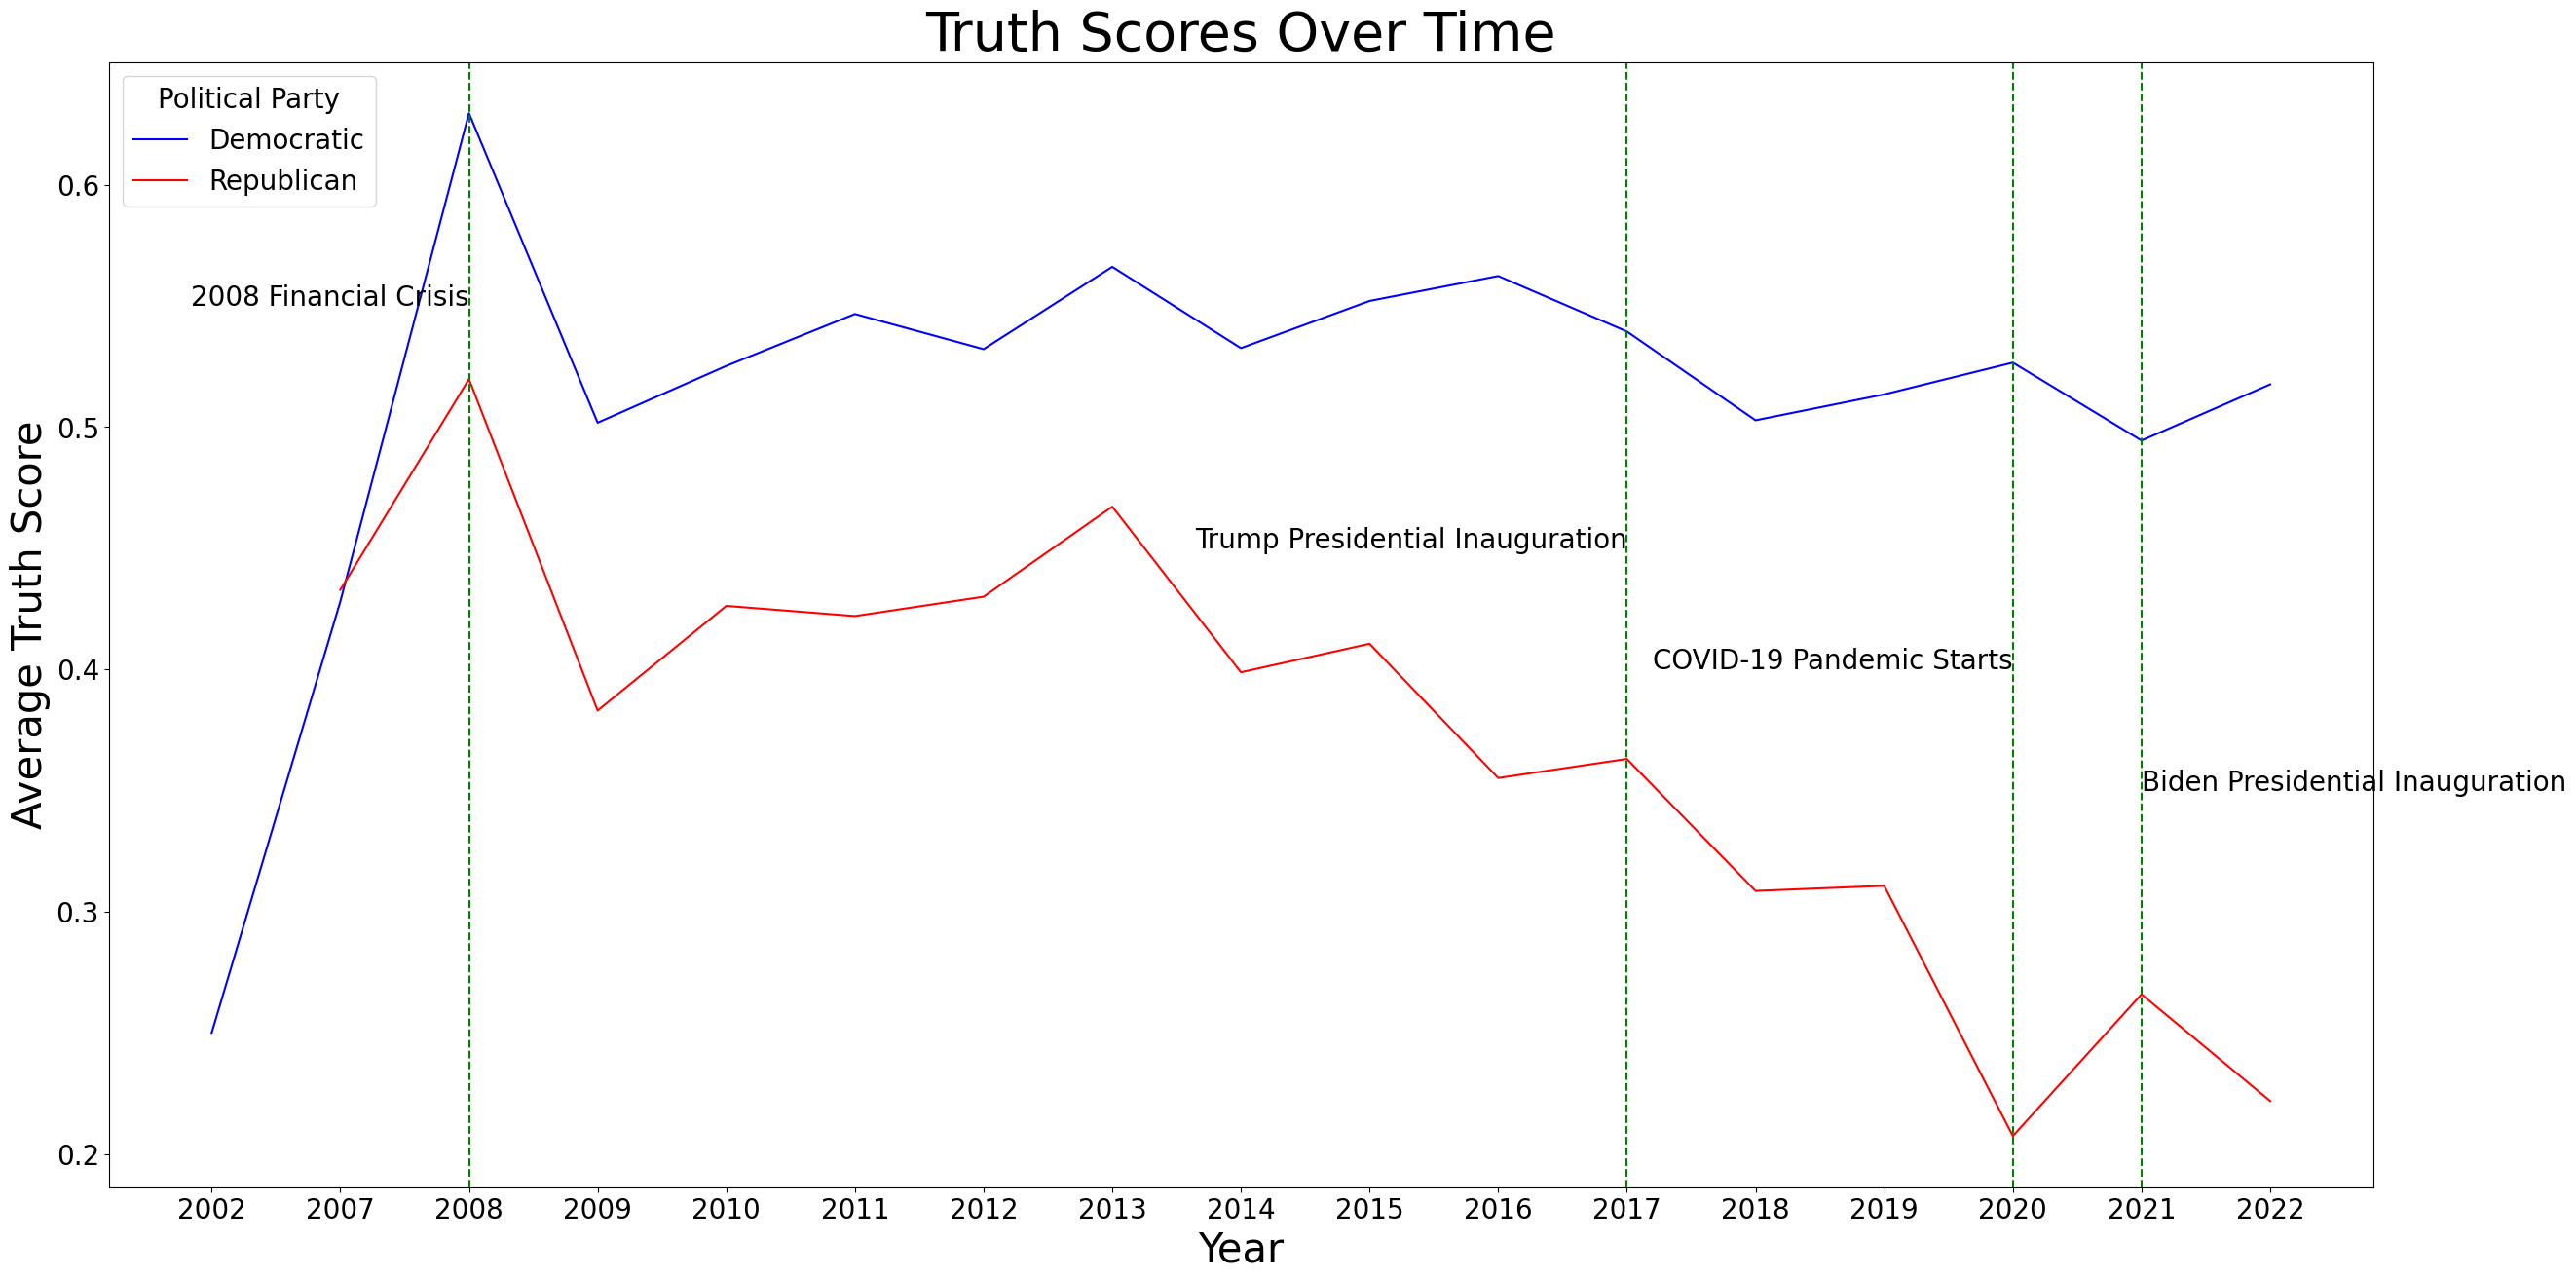

In [19]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(data=df_party, x='statement_year', y='avg_verdict_score', hue='party_affiliation_refined',
             palette={'Democratic': 'blue','Republican': 'red'})

ax.set_title('Truth Scores Over Time', fontsize=40)
ax.set_ylabel('Average Truth Score', fontsize=30)
ax.set_xlabel('Year', fontsize=30)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(title='Political Party', title_fontsize=20, fontsize=20)

date = "2008"
ax.axvline(date, linestyle = '--', color = 'green')
ax.text(x = date, y = 0.55, s = '2008 Financial Crisis', ha = 'right', fontsize = 20)

date = "2017"
ax.axvline(date, linestyle = '--', color = 'green')
ax.text(x = date, y = 0.45, s = 'Trump Presidential Inauguration', ha = 'right', fontsize = 20)

date = "2020"
ax.axvline(date, linestyle = '--', color = 'green')
ax.text(x = date, y = 0.4, s = 'COVID-19 Pandemic Starts', ha = 'right', fontsize = 20)

date = "2021"
ax.axvline(date, linestyle = '--', color = 'green')
ax.text(x = date, y = 0.35, s = 'Biden Presidential Inauguration', ha = 'left', fontsize = 20)

plt.show()

## Source Analysis

In [21]:
df_source = df.groupby(['statement_year', 'party_affiliation_refined', 'statement_source'])['verdict_score'].mean().reset_index()
df_source = df_source.rename(columns={'verdict_score': 'avg_verdict_score'})
df_source

,statement_year,party_affiliation_refined,statement_source,avg_verdict_score
0,2002,Democratic,campaign,0.250000
1,2007,Democratic,advertisement,0.576923
2,2007,Democratic,campaign,0.312500
3,2007,Democratic,news,0.750000
4,2007,Democratic,other,0.301724
...,...,...,...,...
381,2022,Republican,social_media,0.262500
382,2022,Republican,speech,0.272727
383,2022,Republican,statement,0.111111
384,2022,Republican,television,0.000000


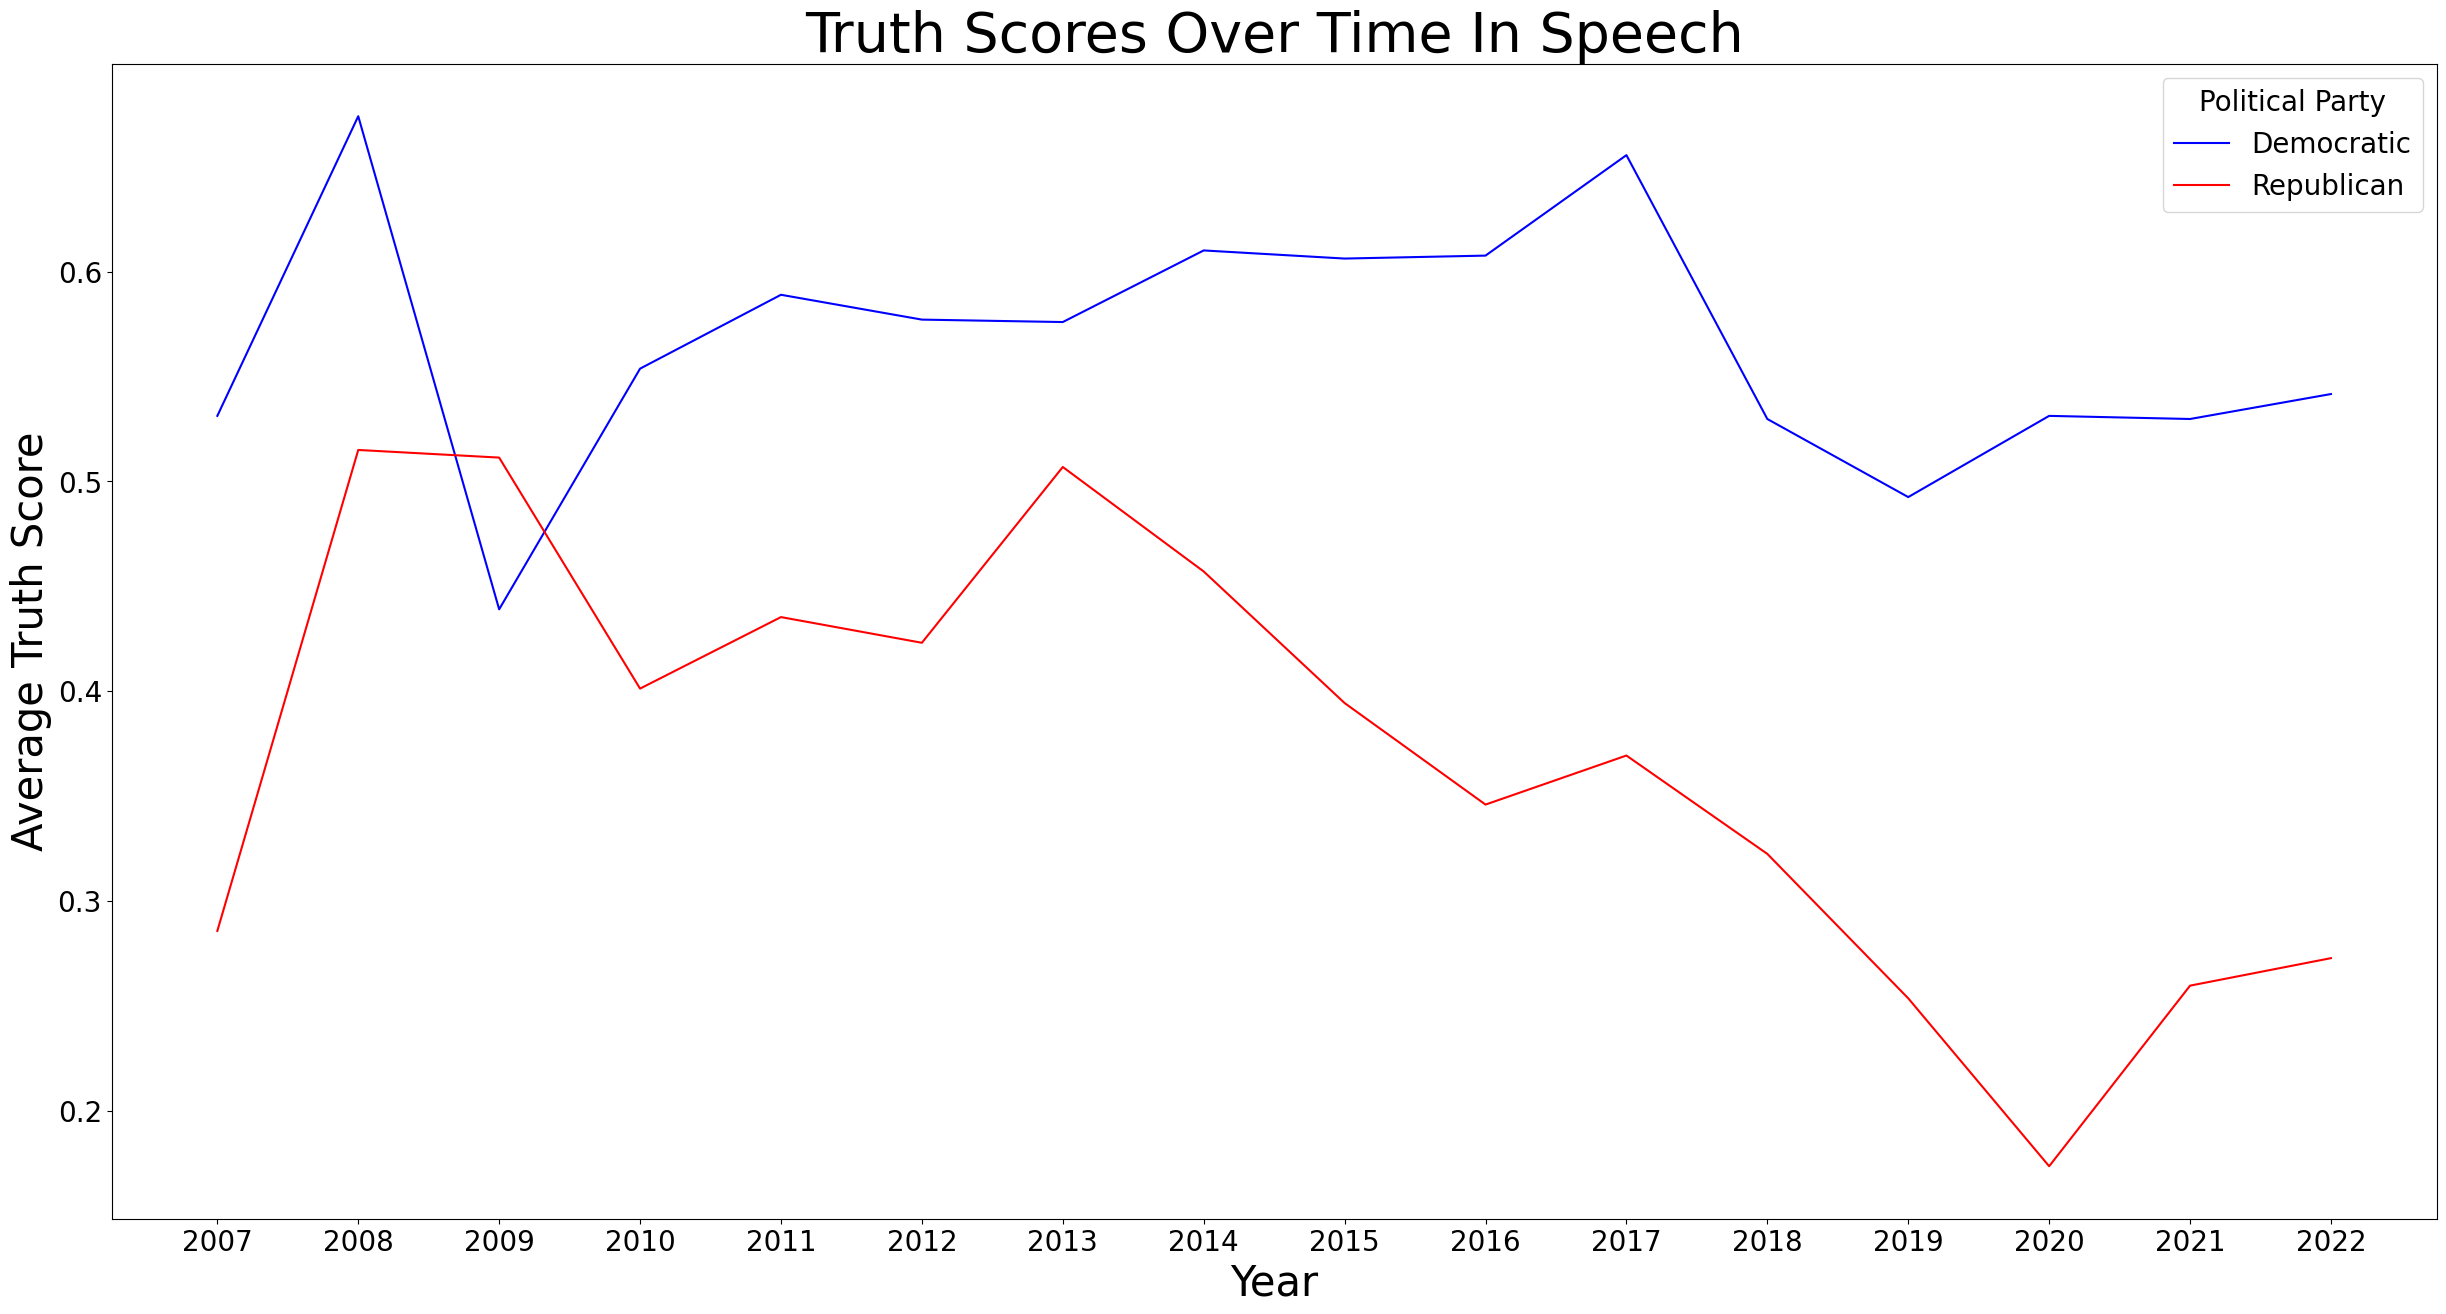

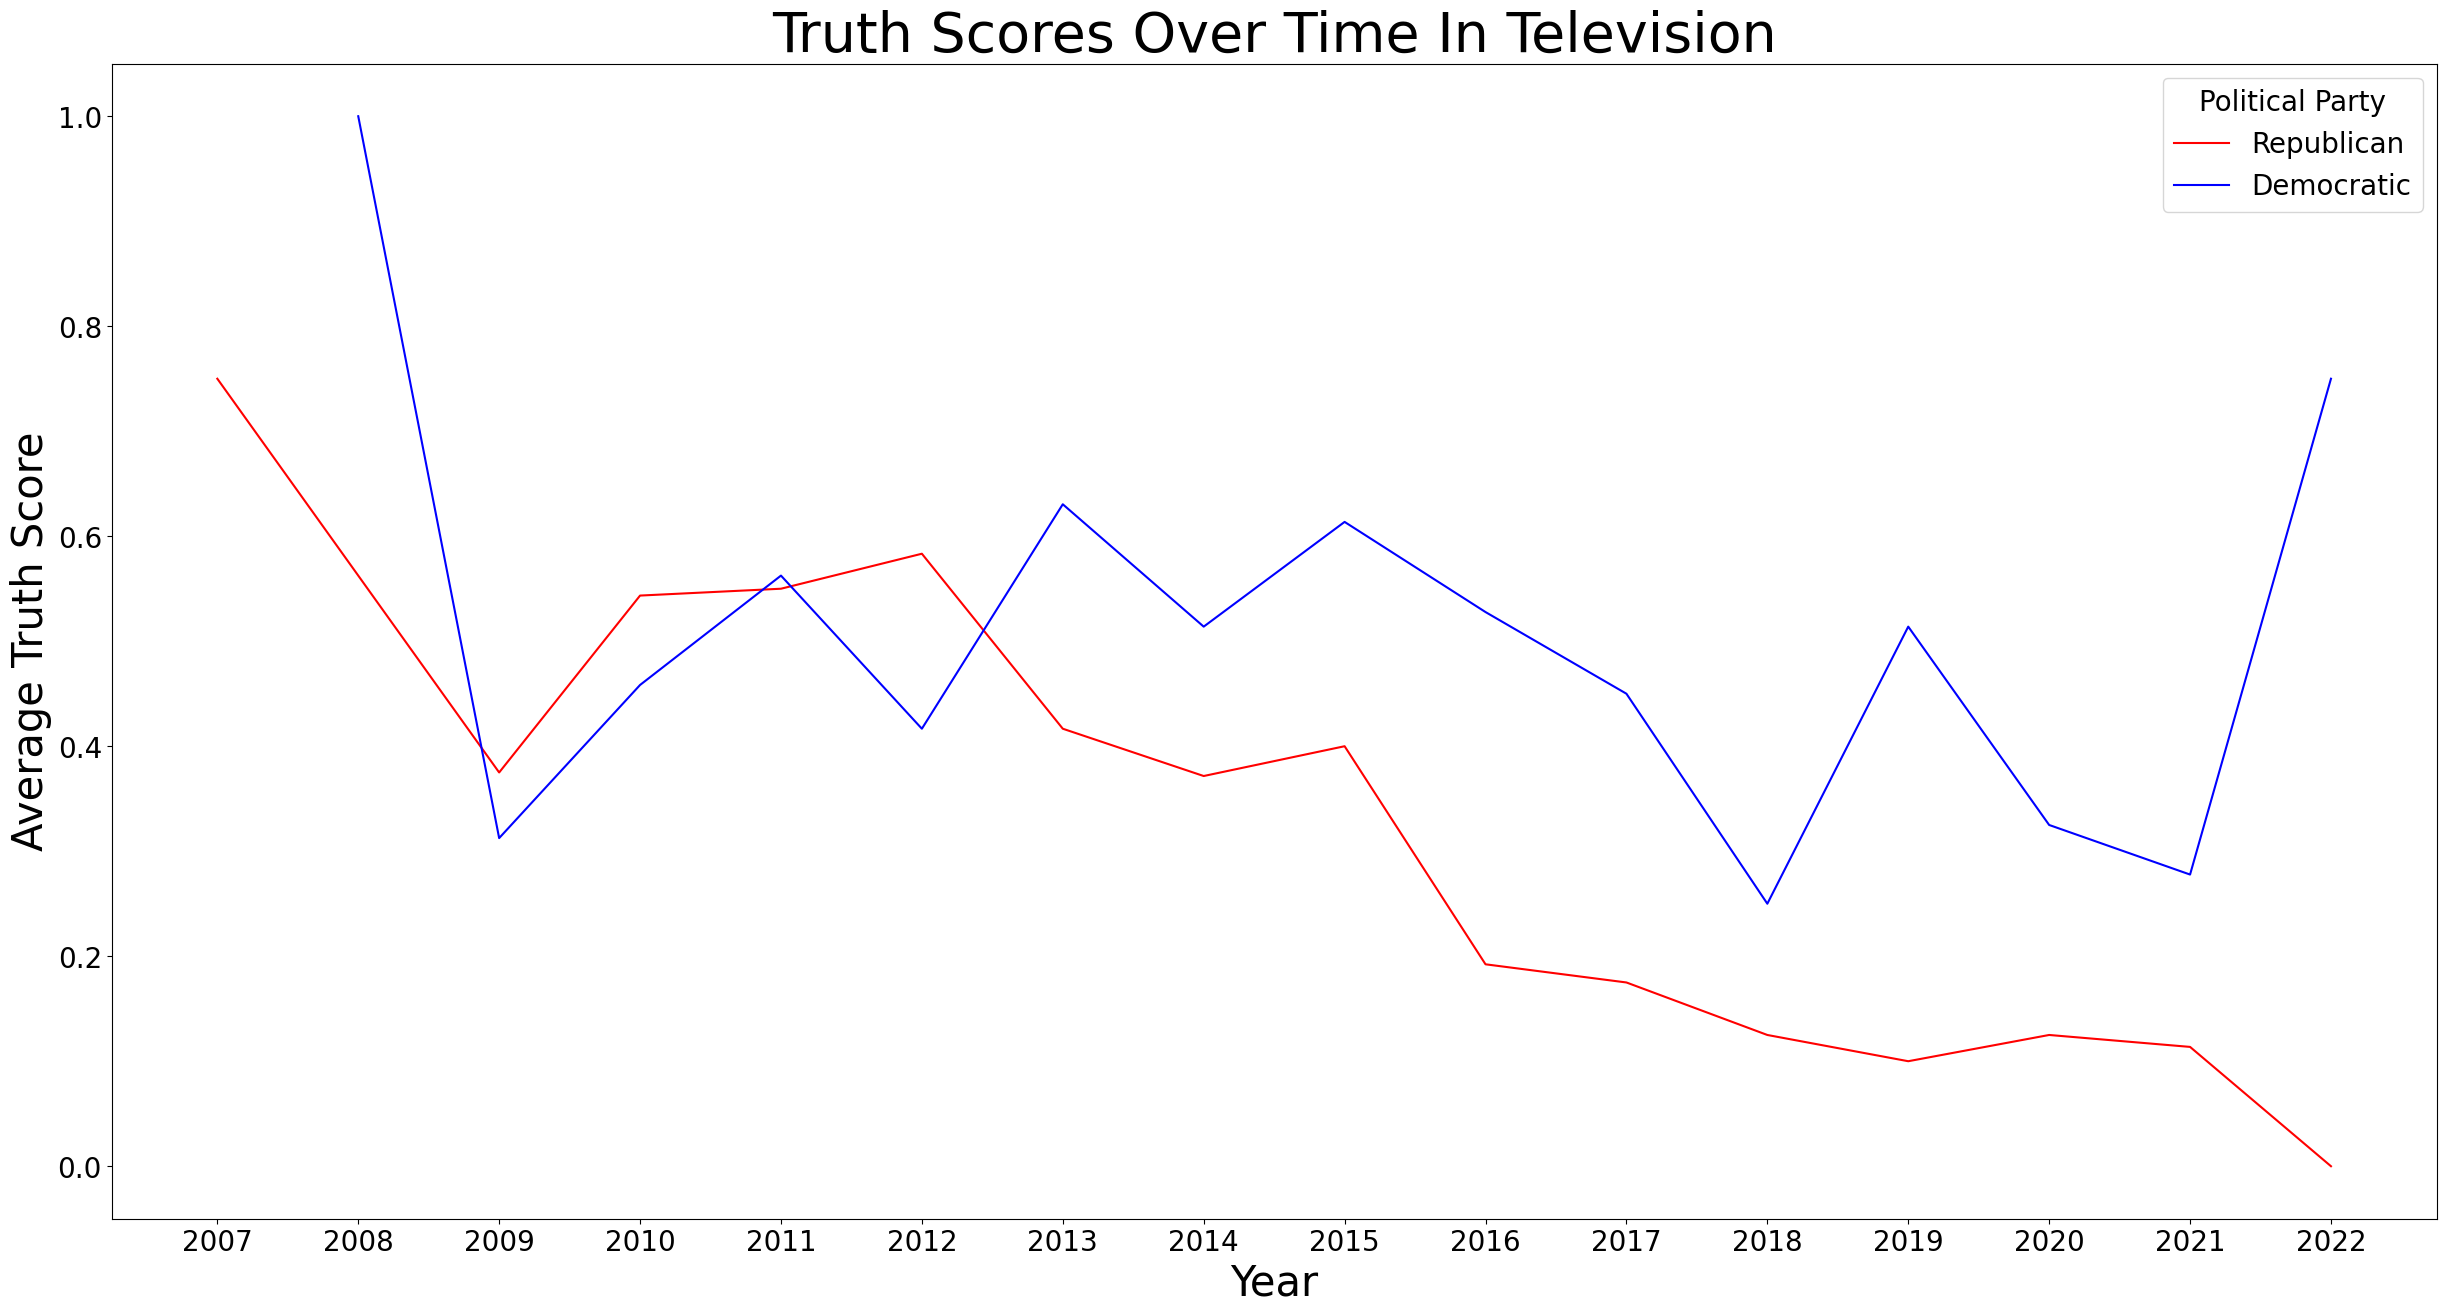

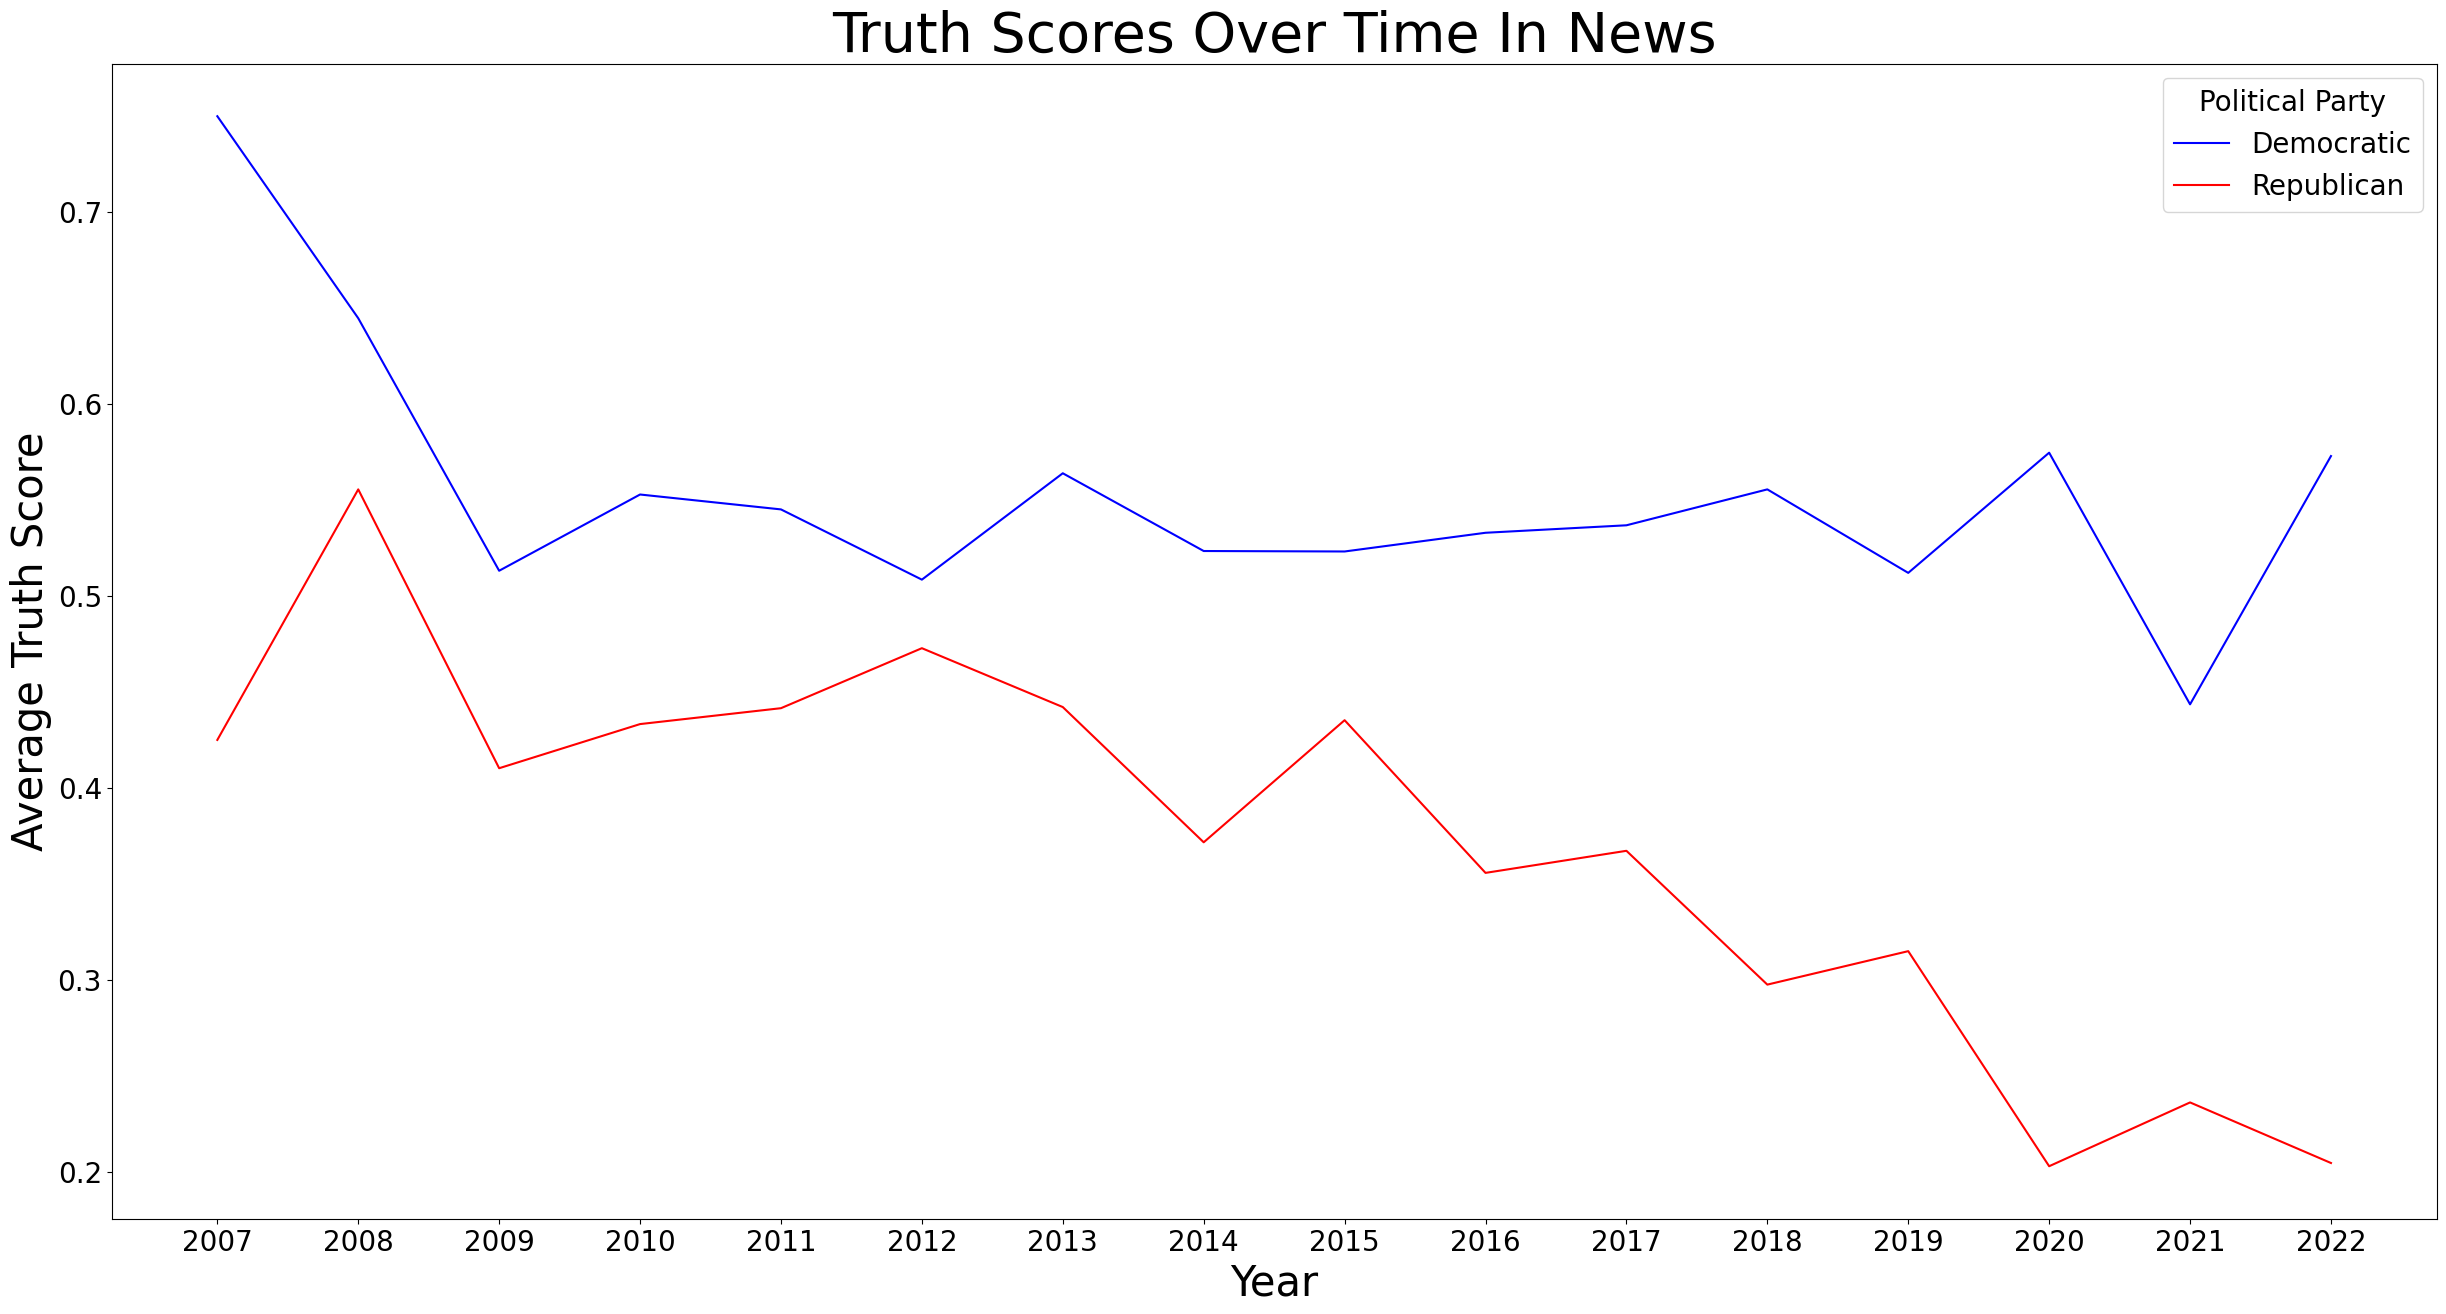

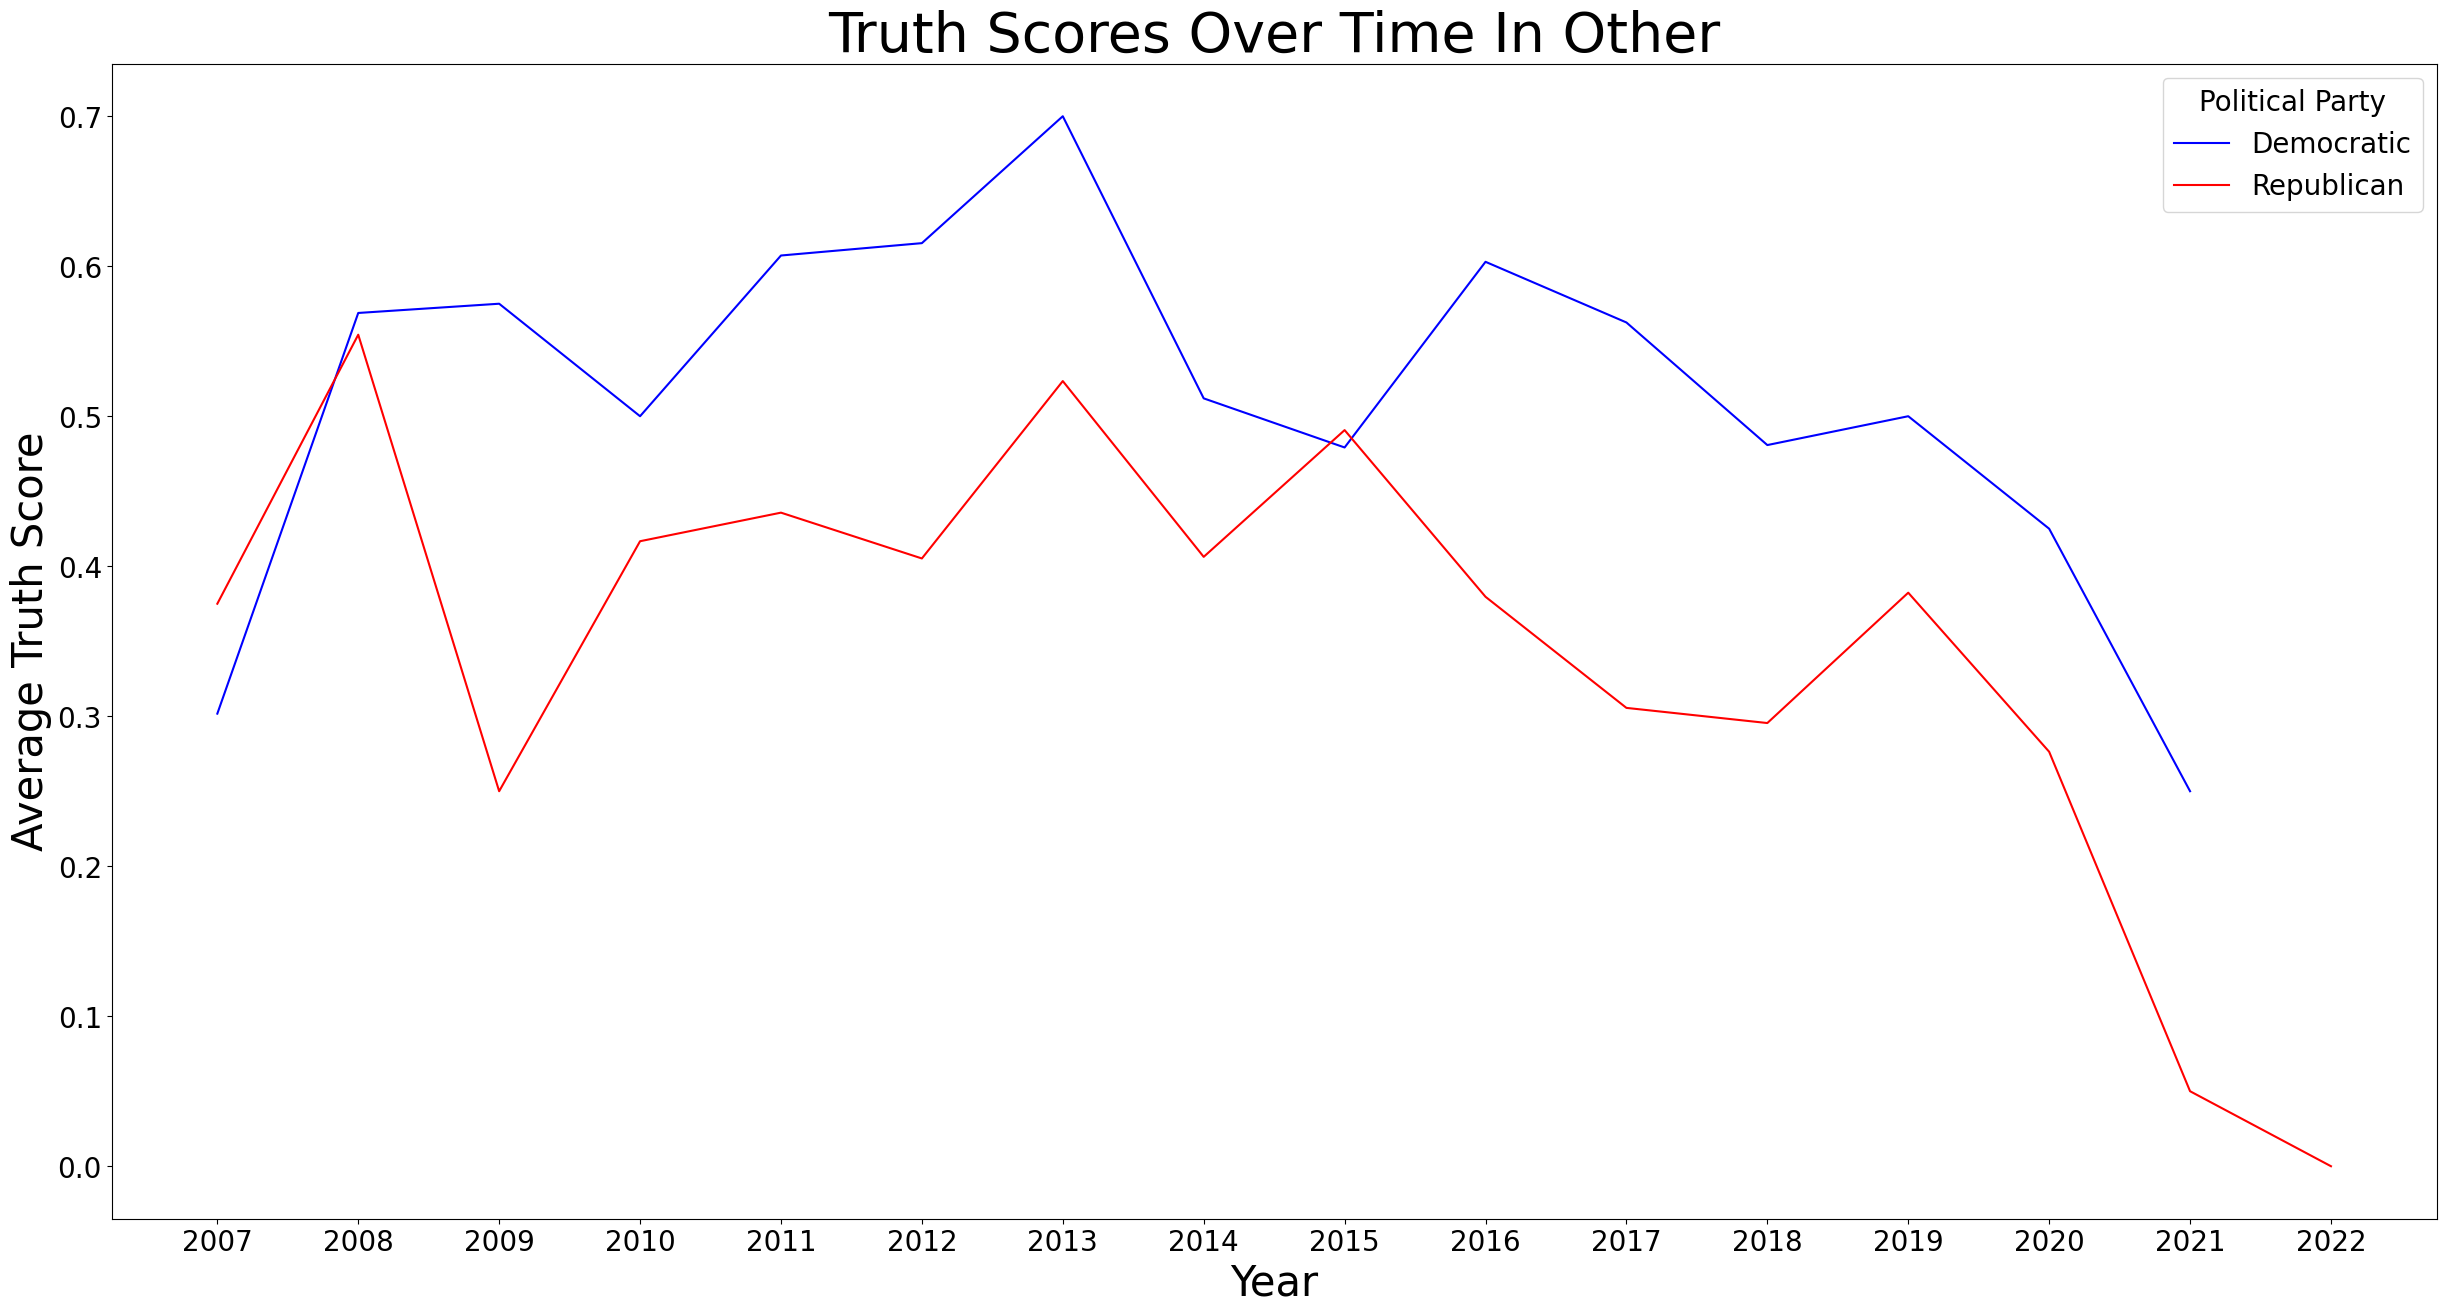

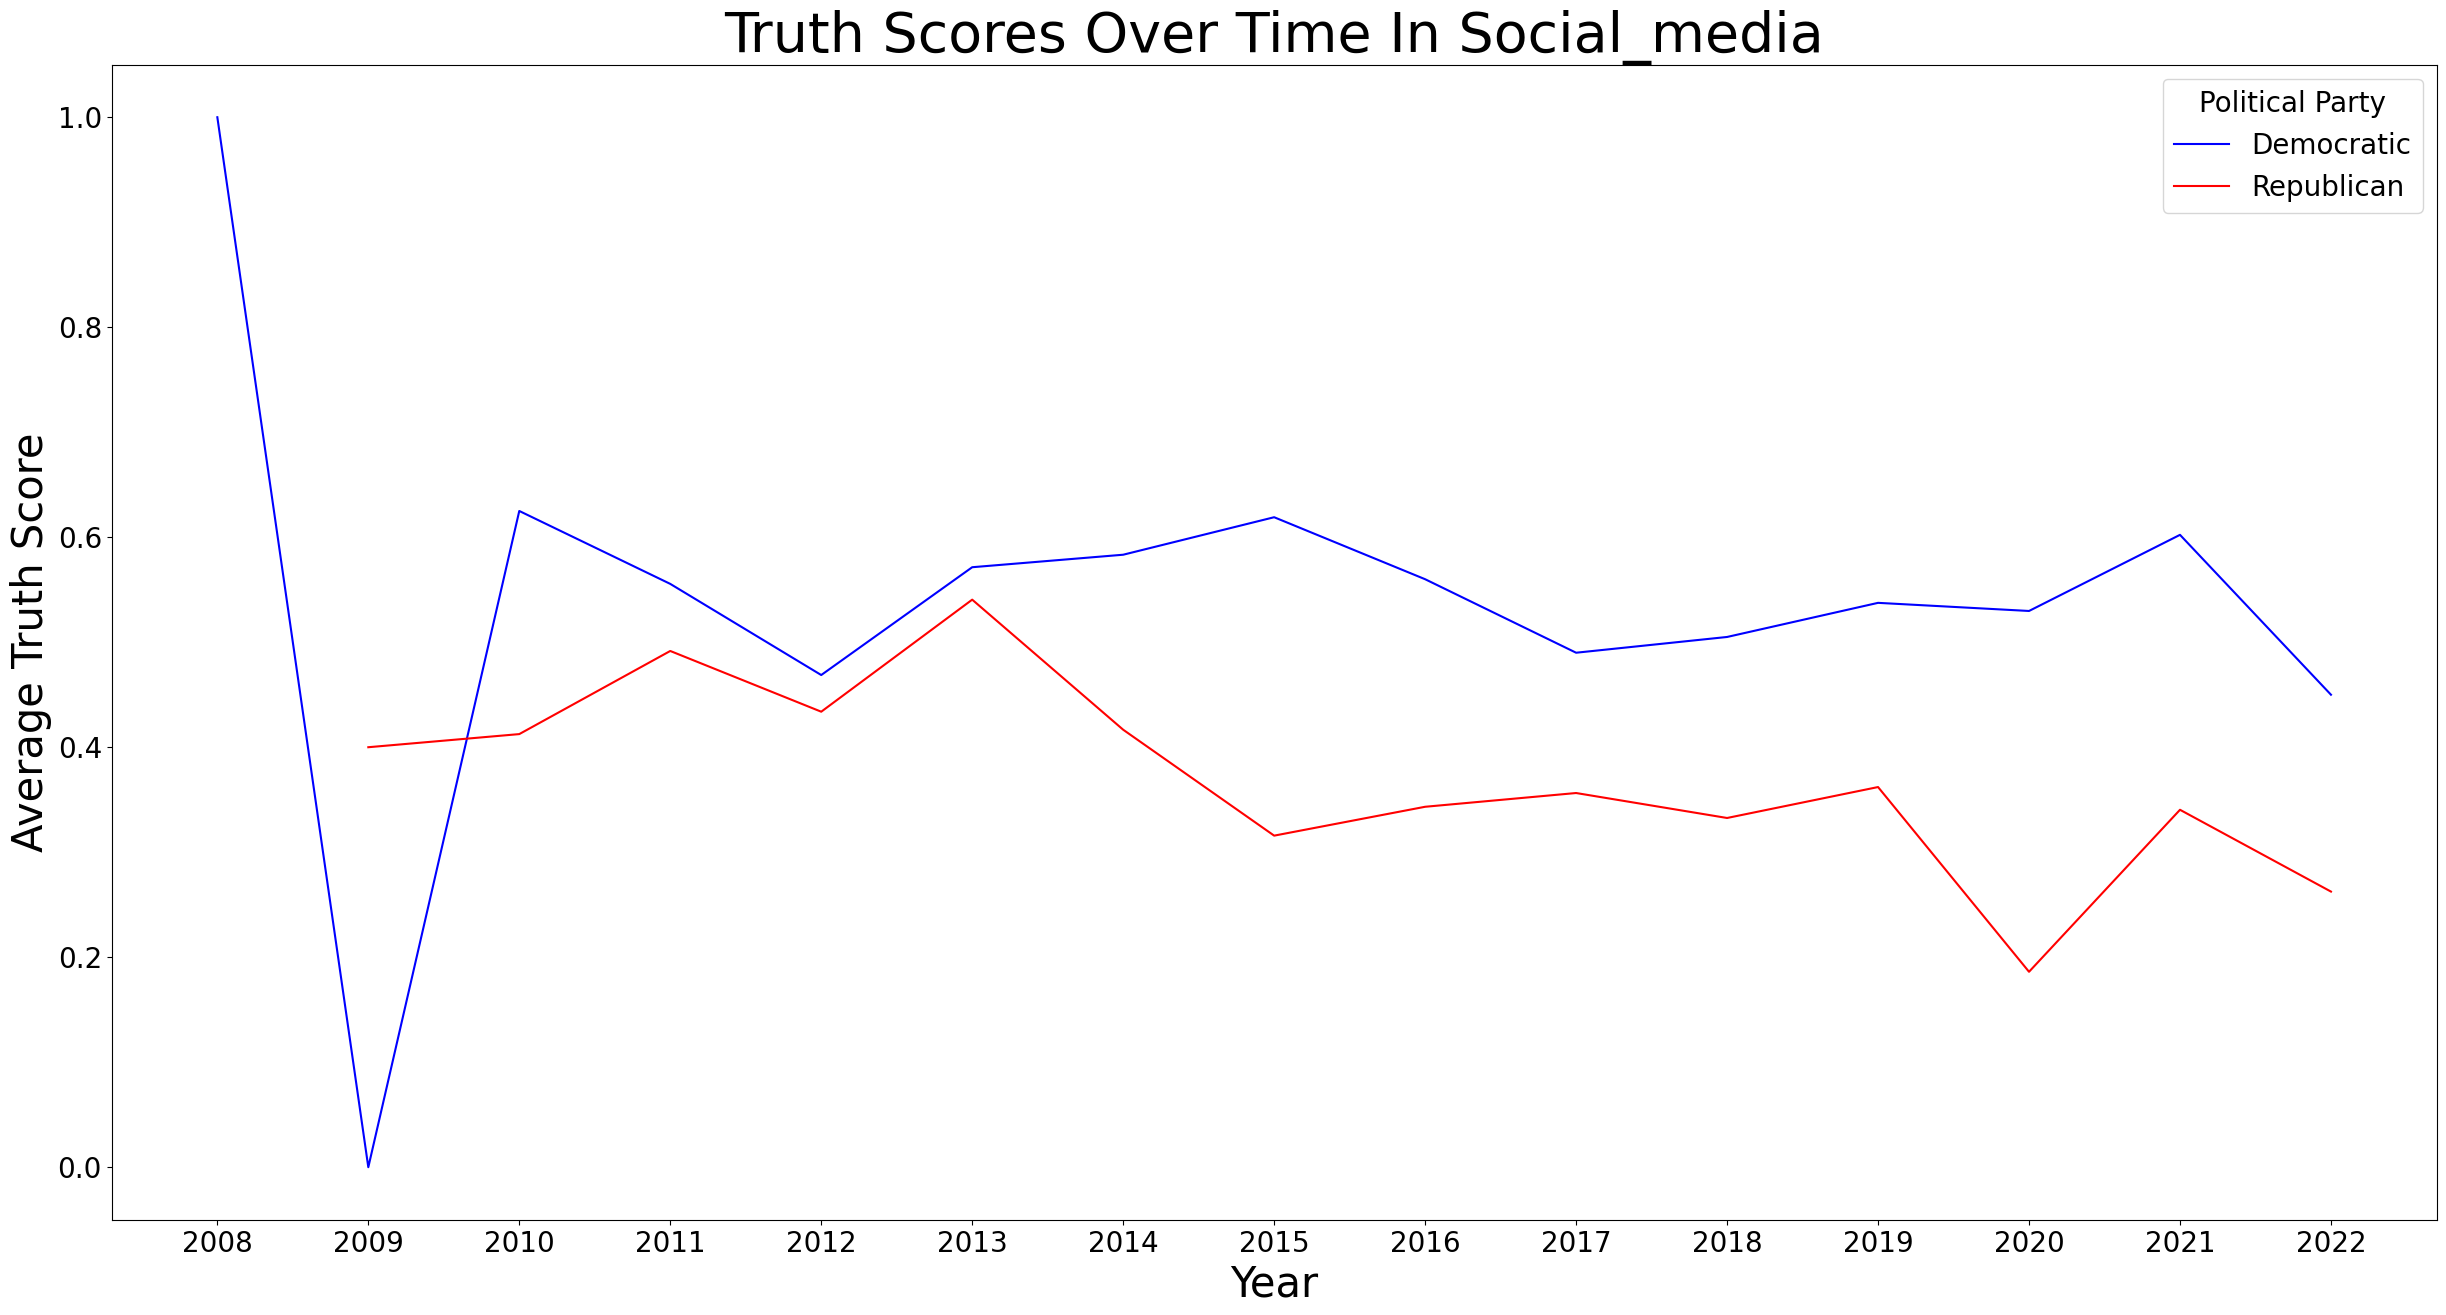

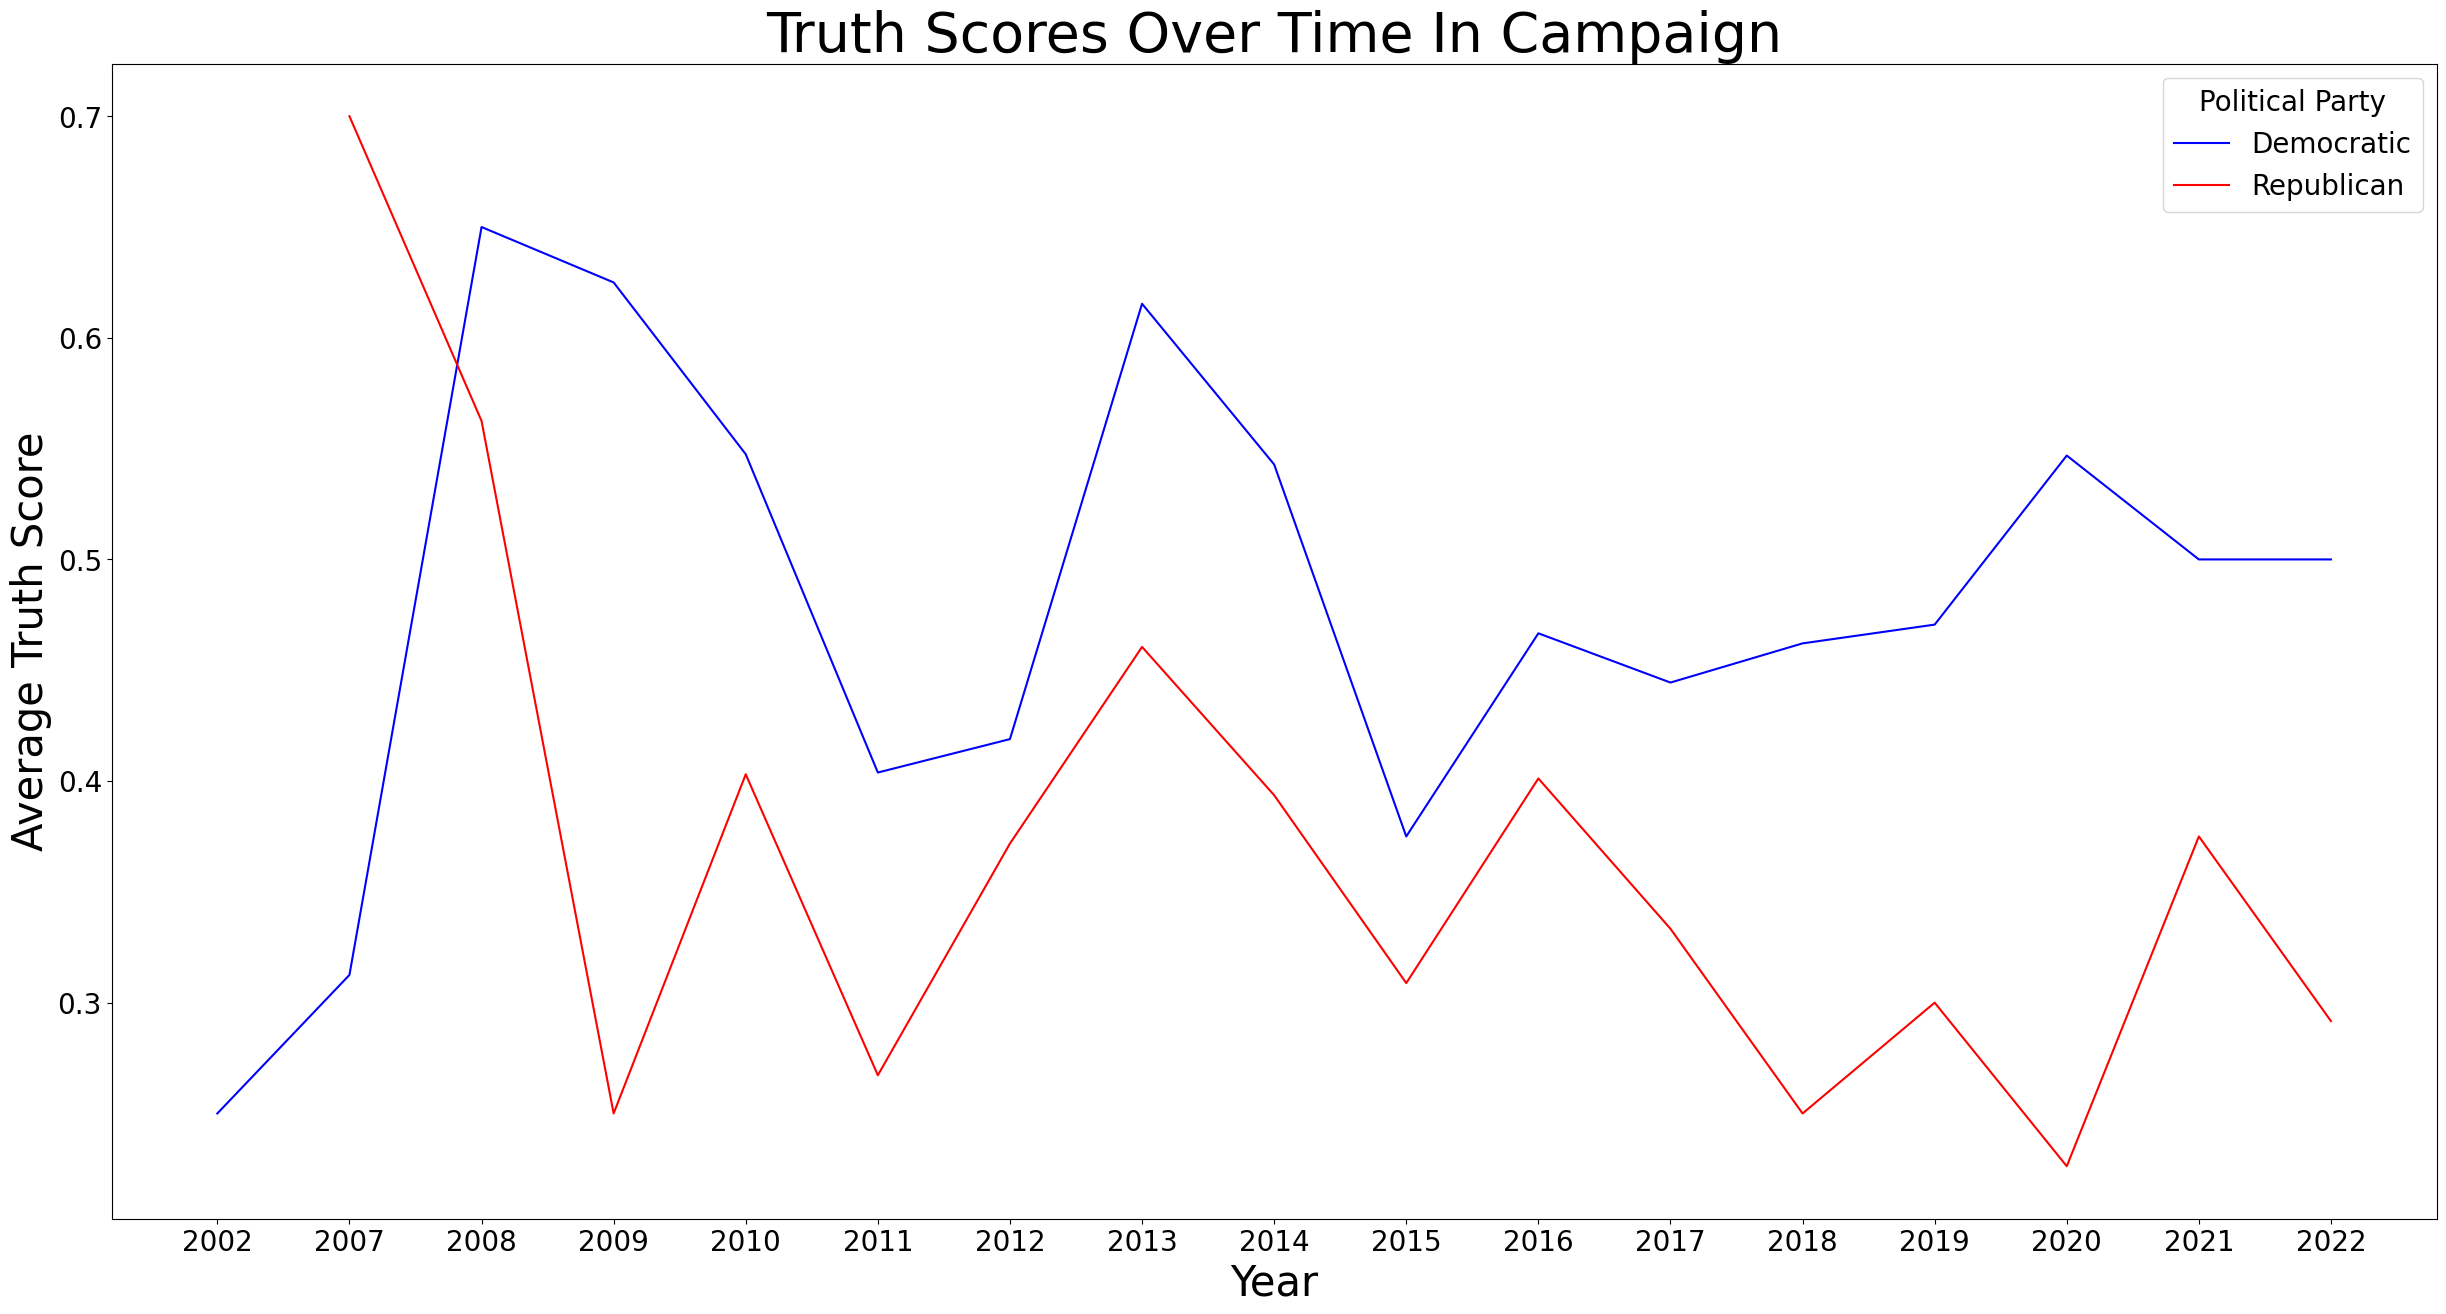

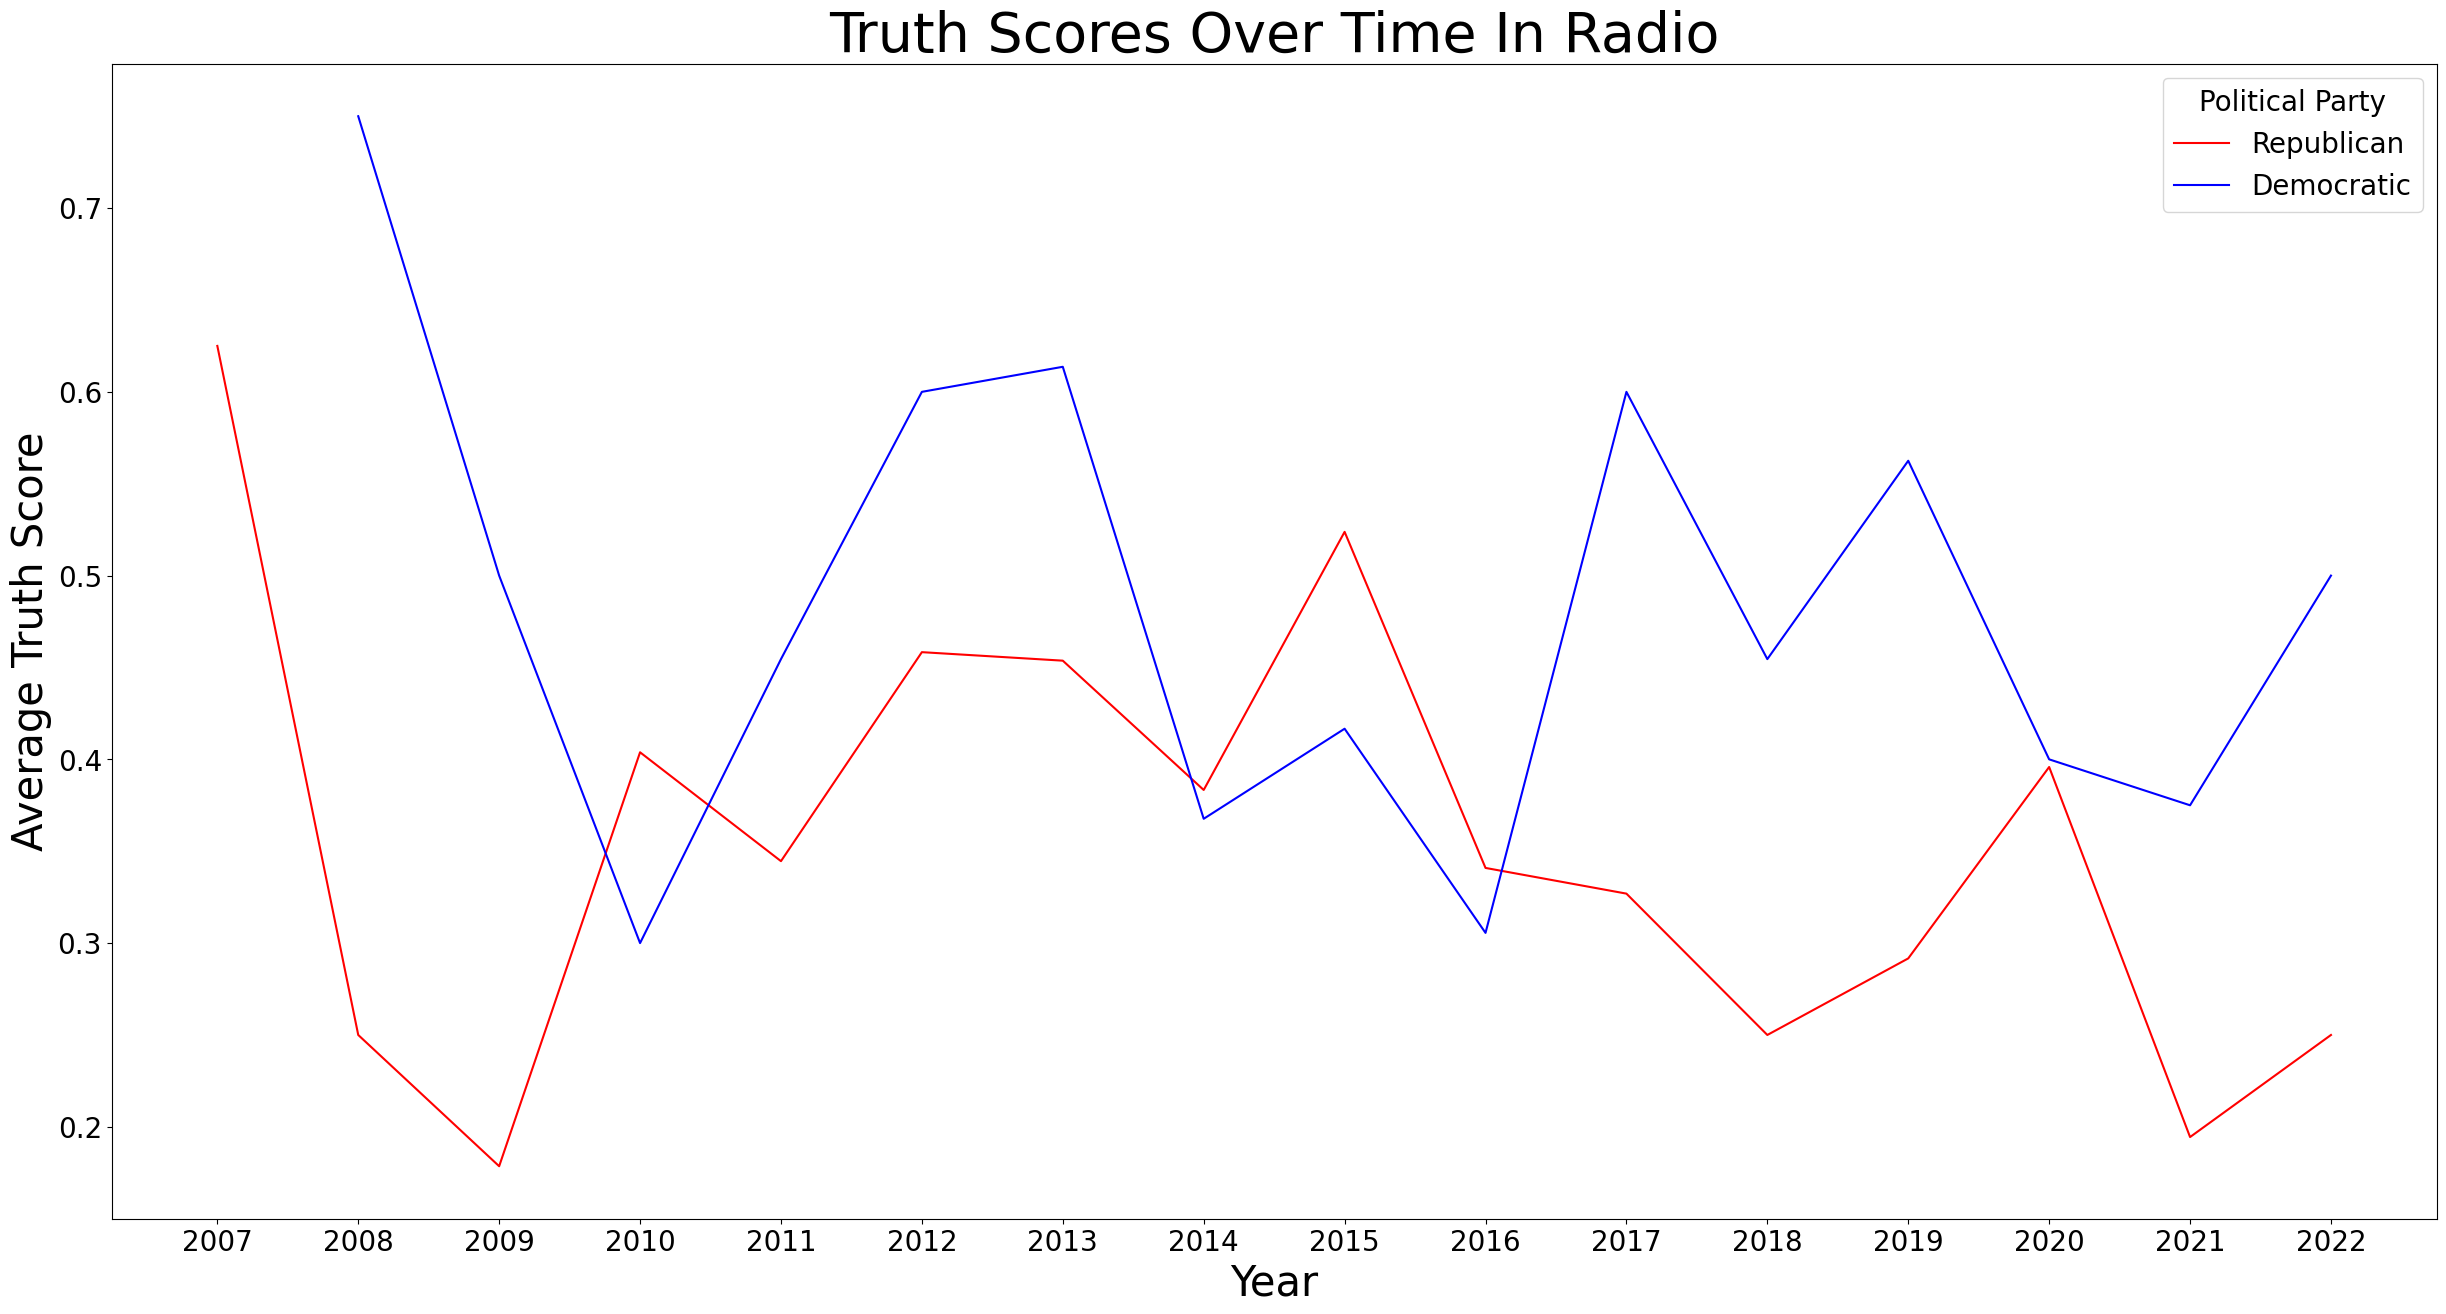

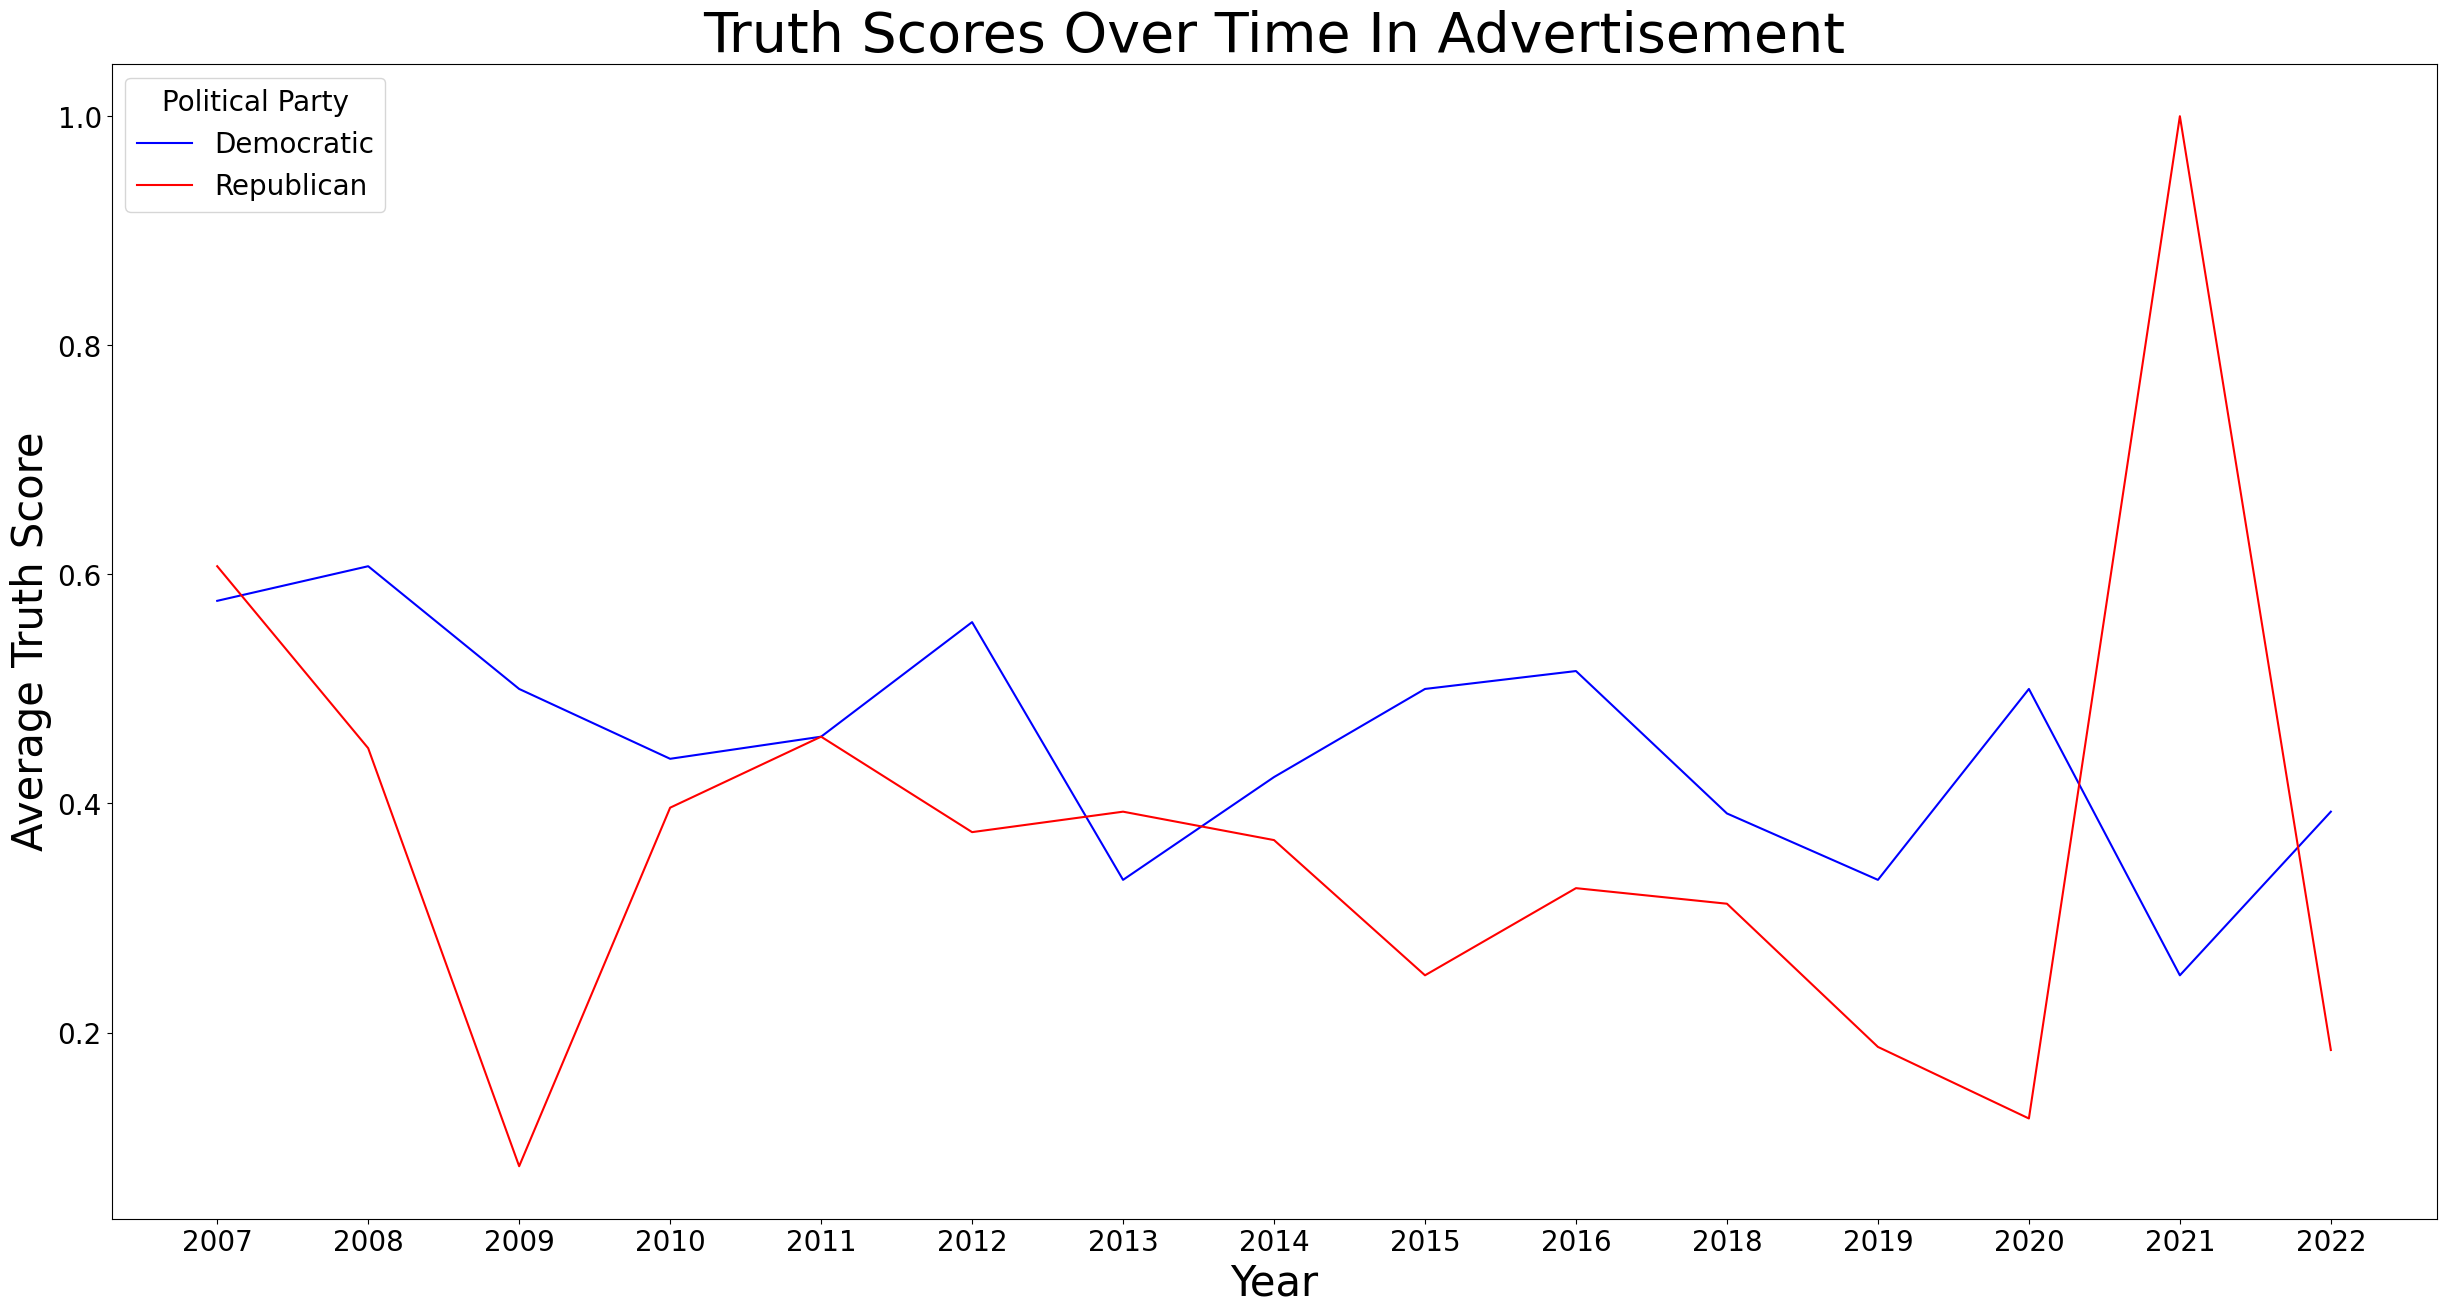

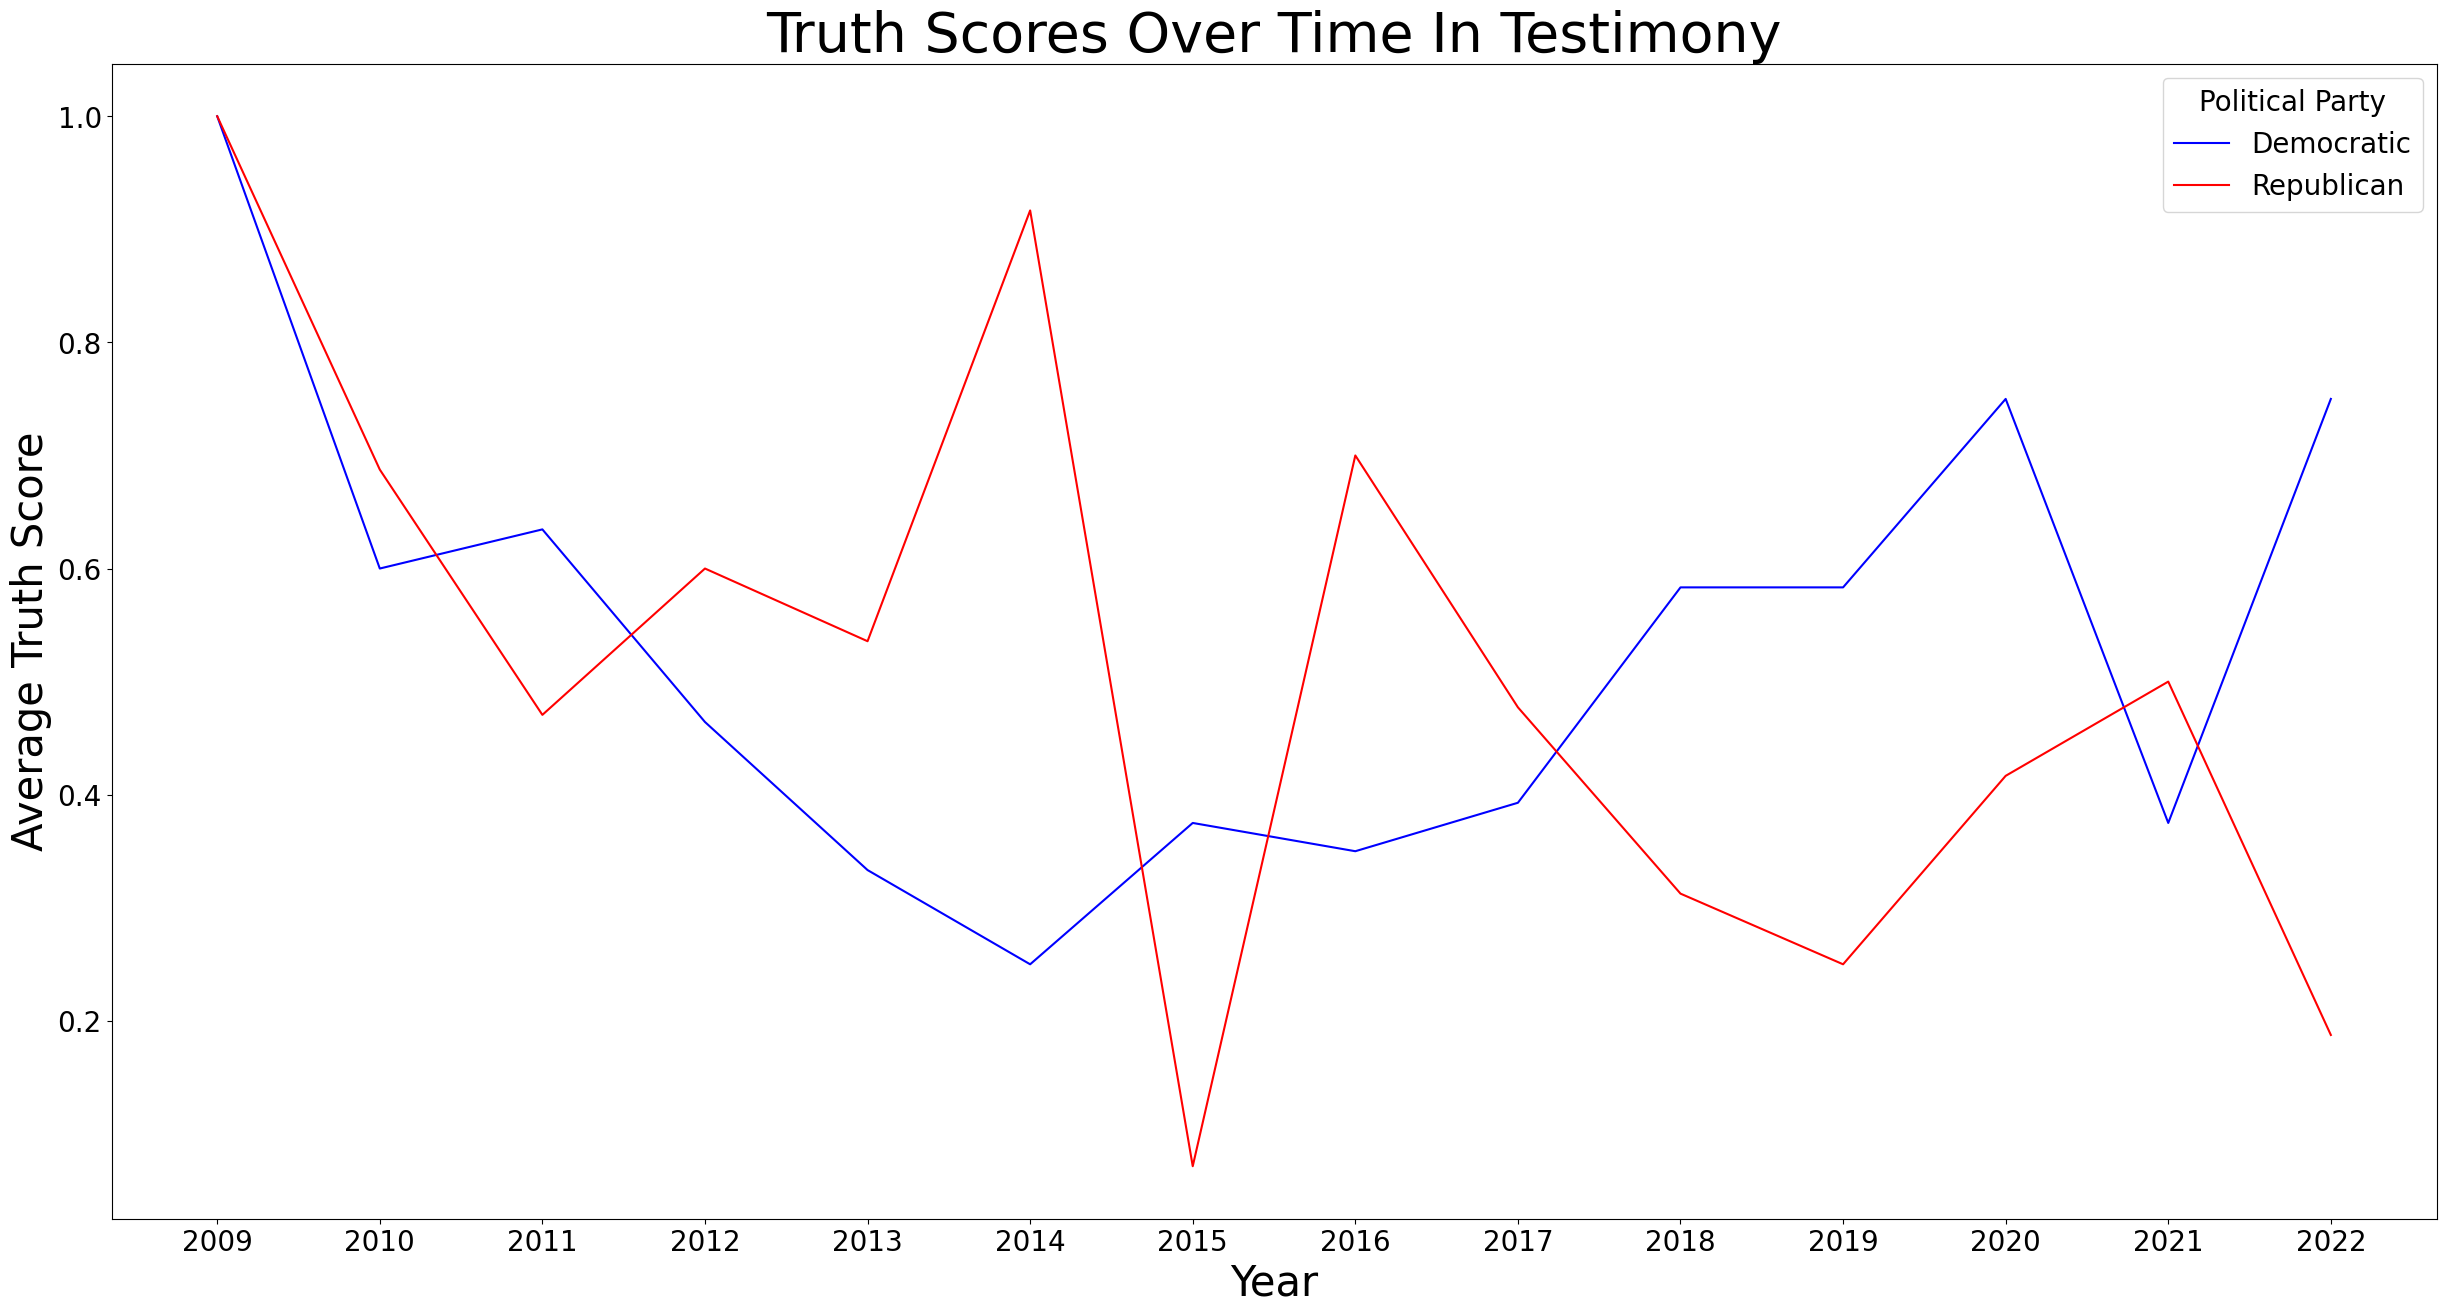

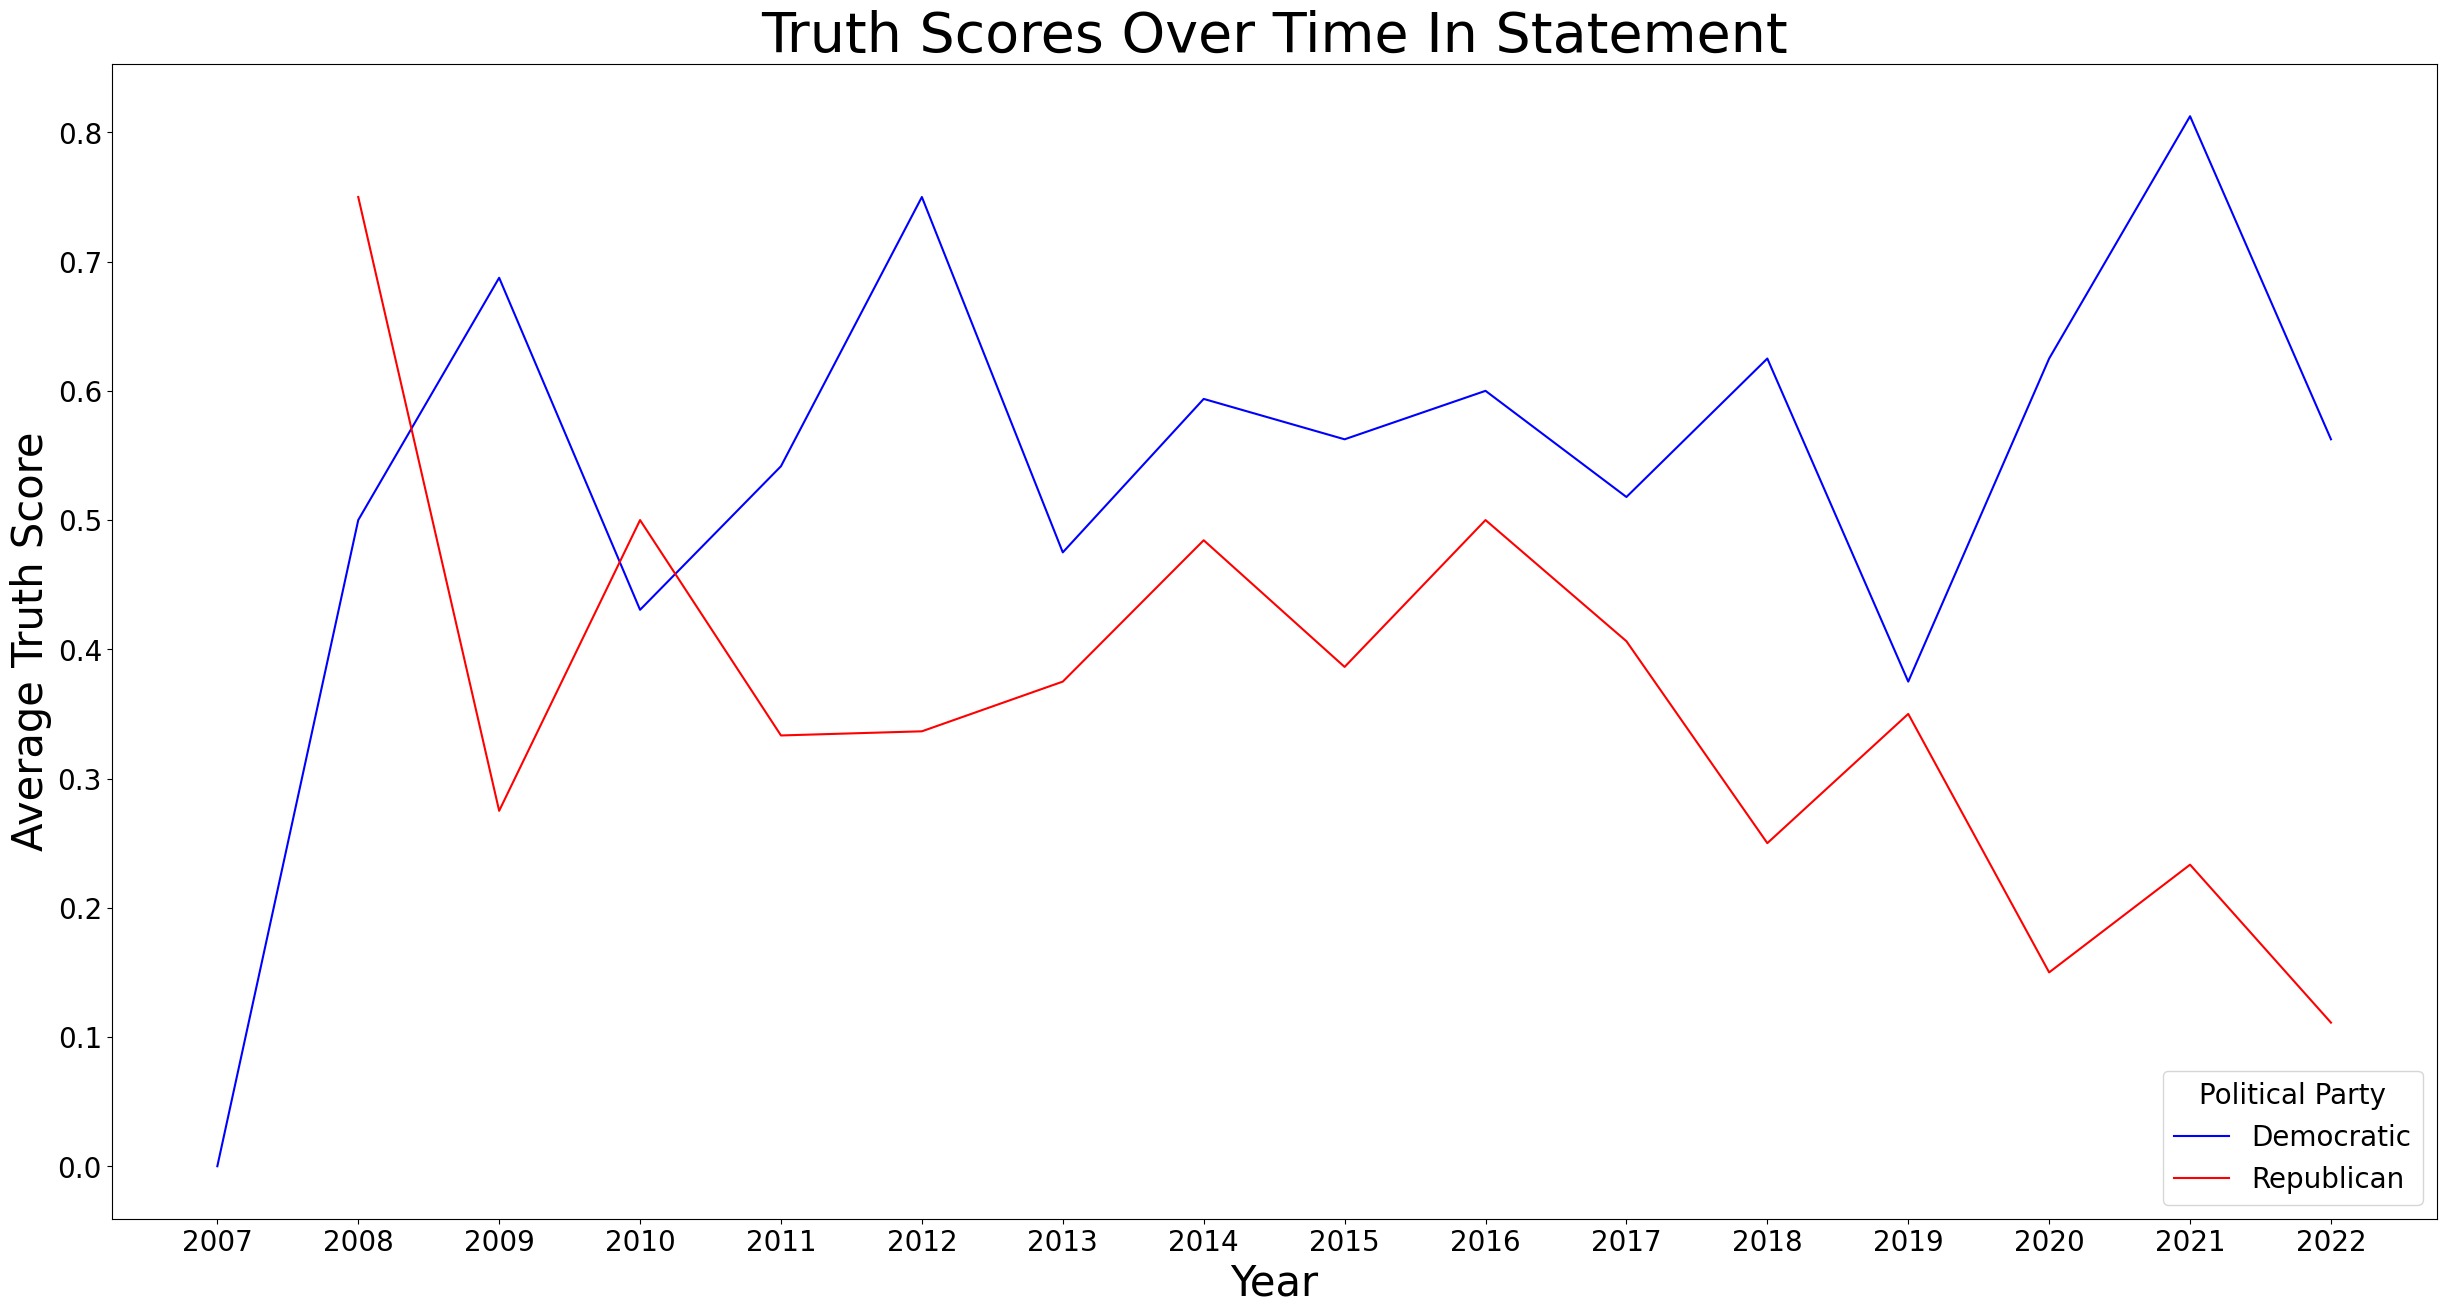

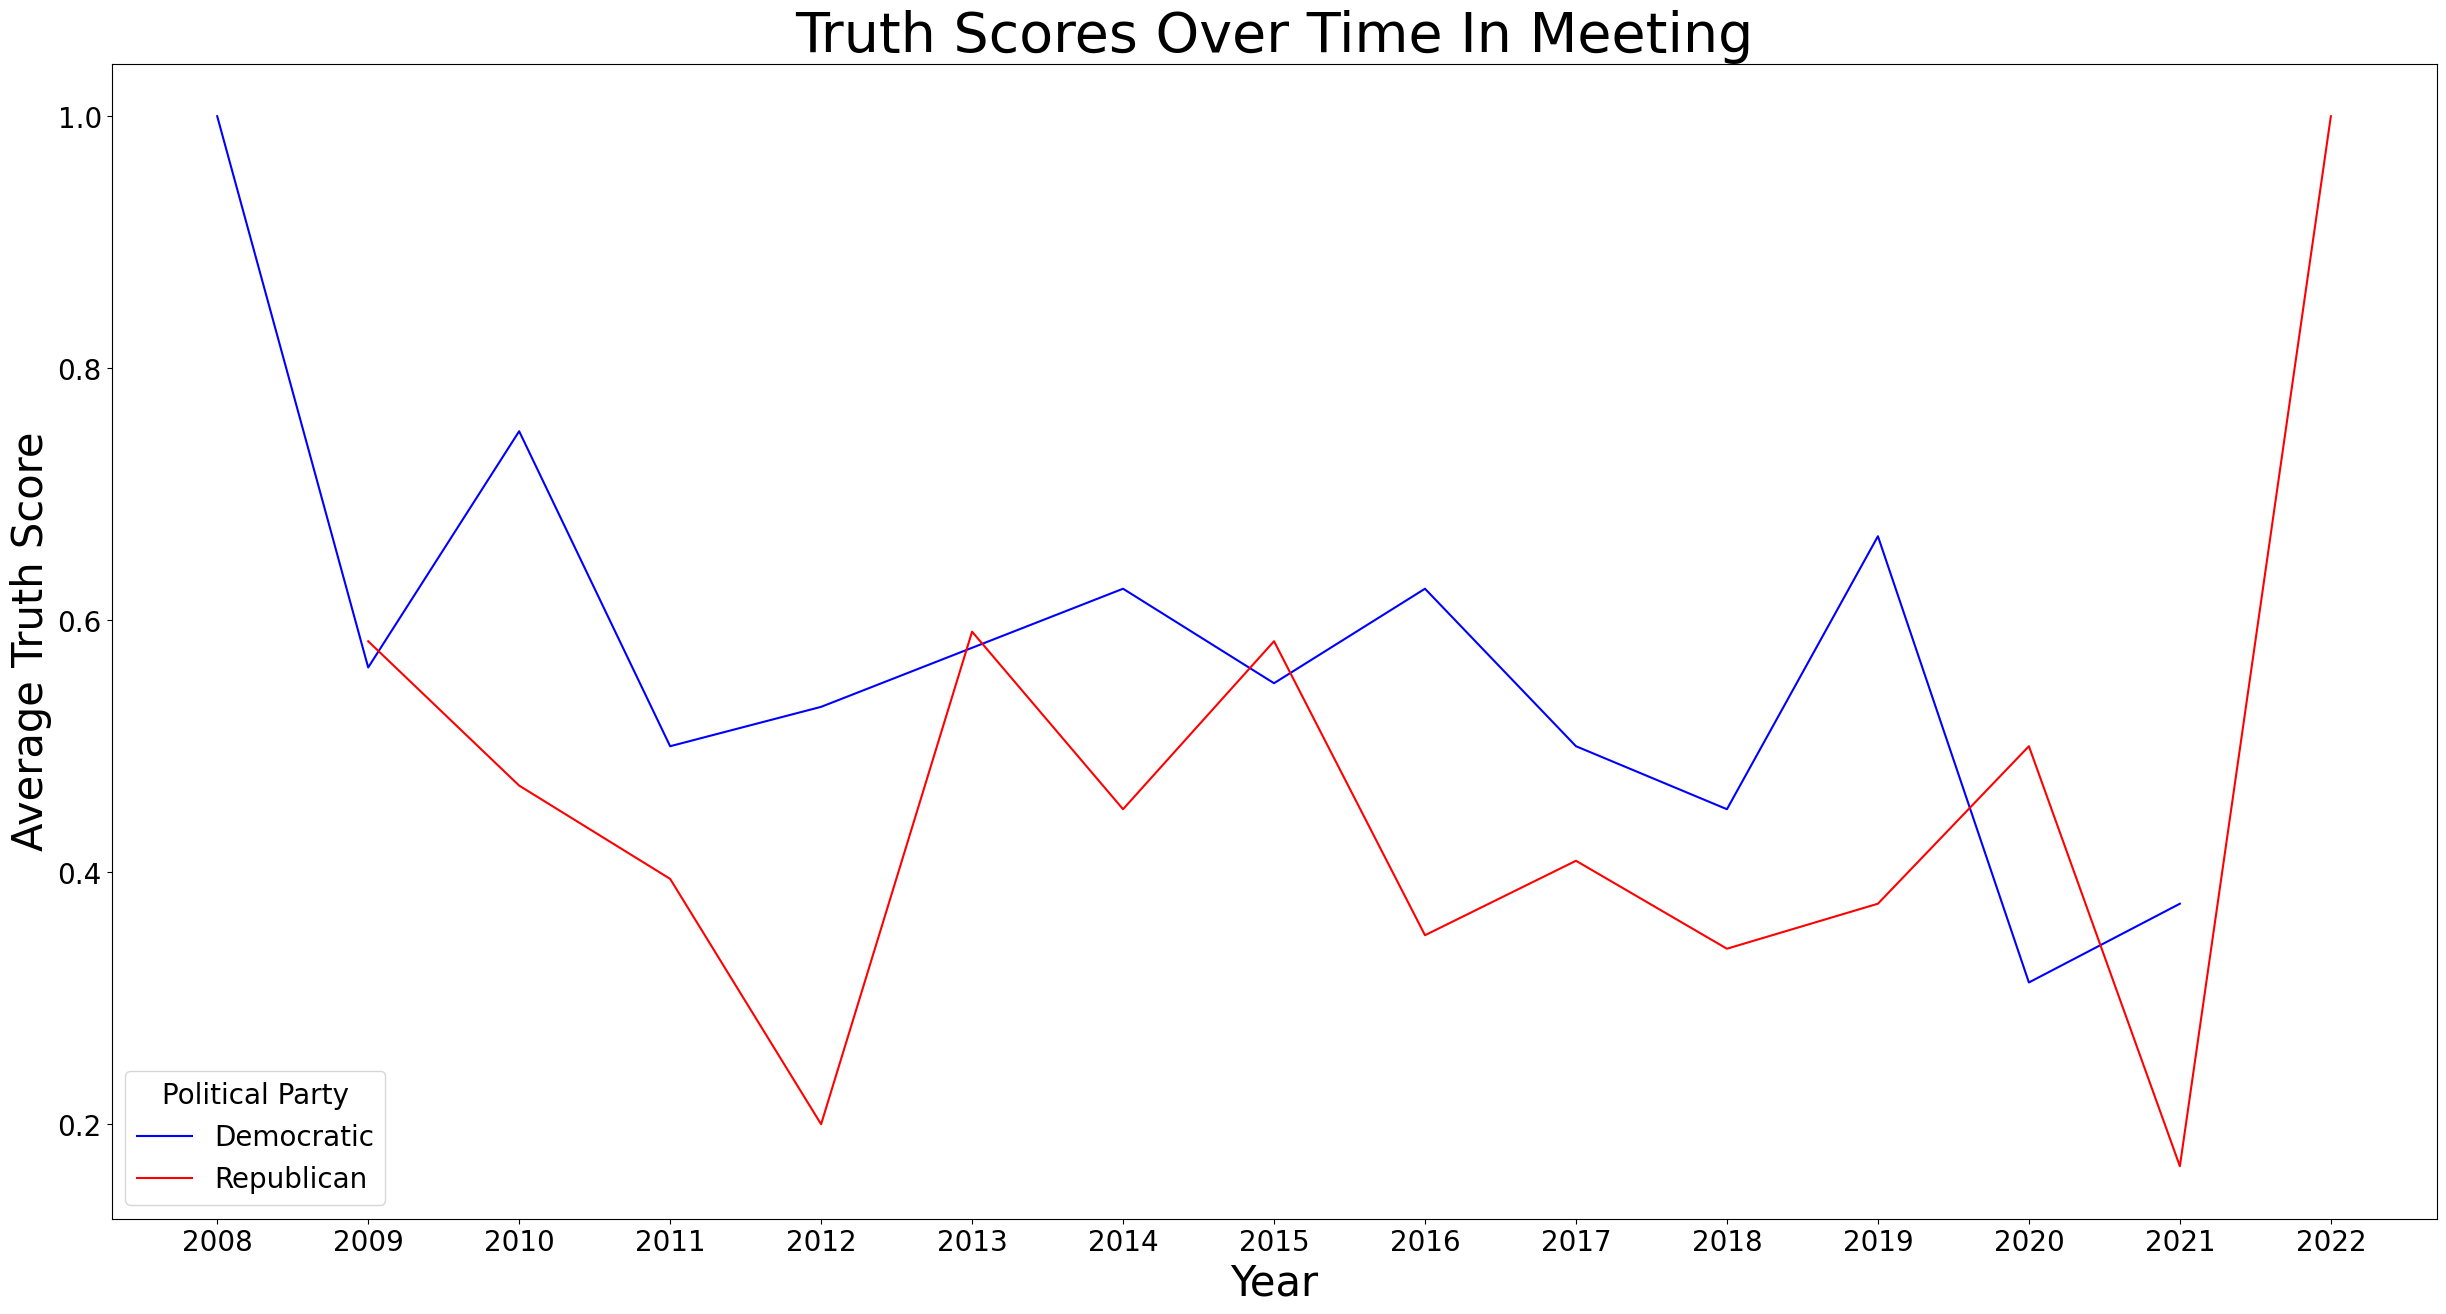

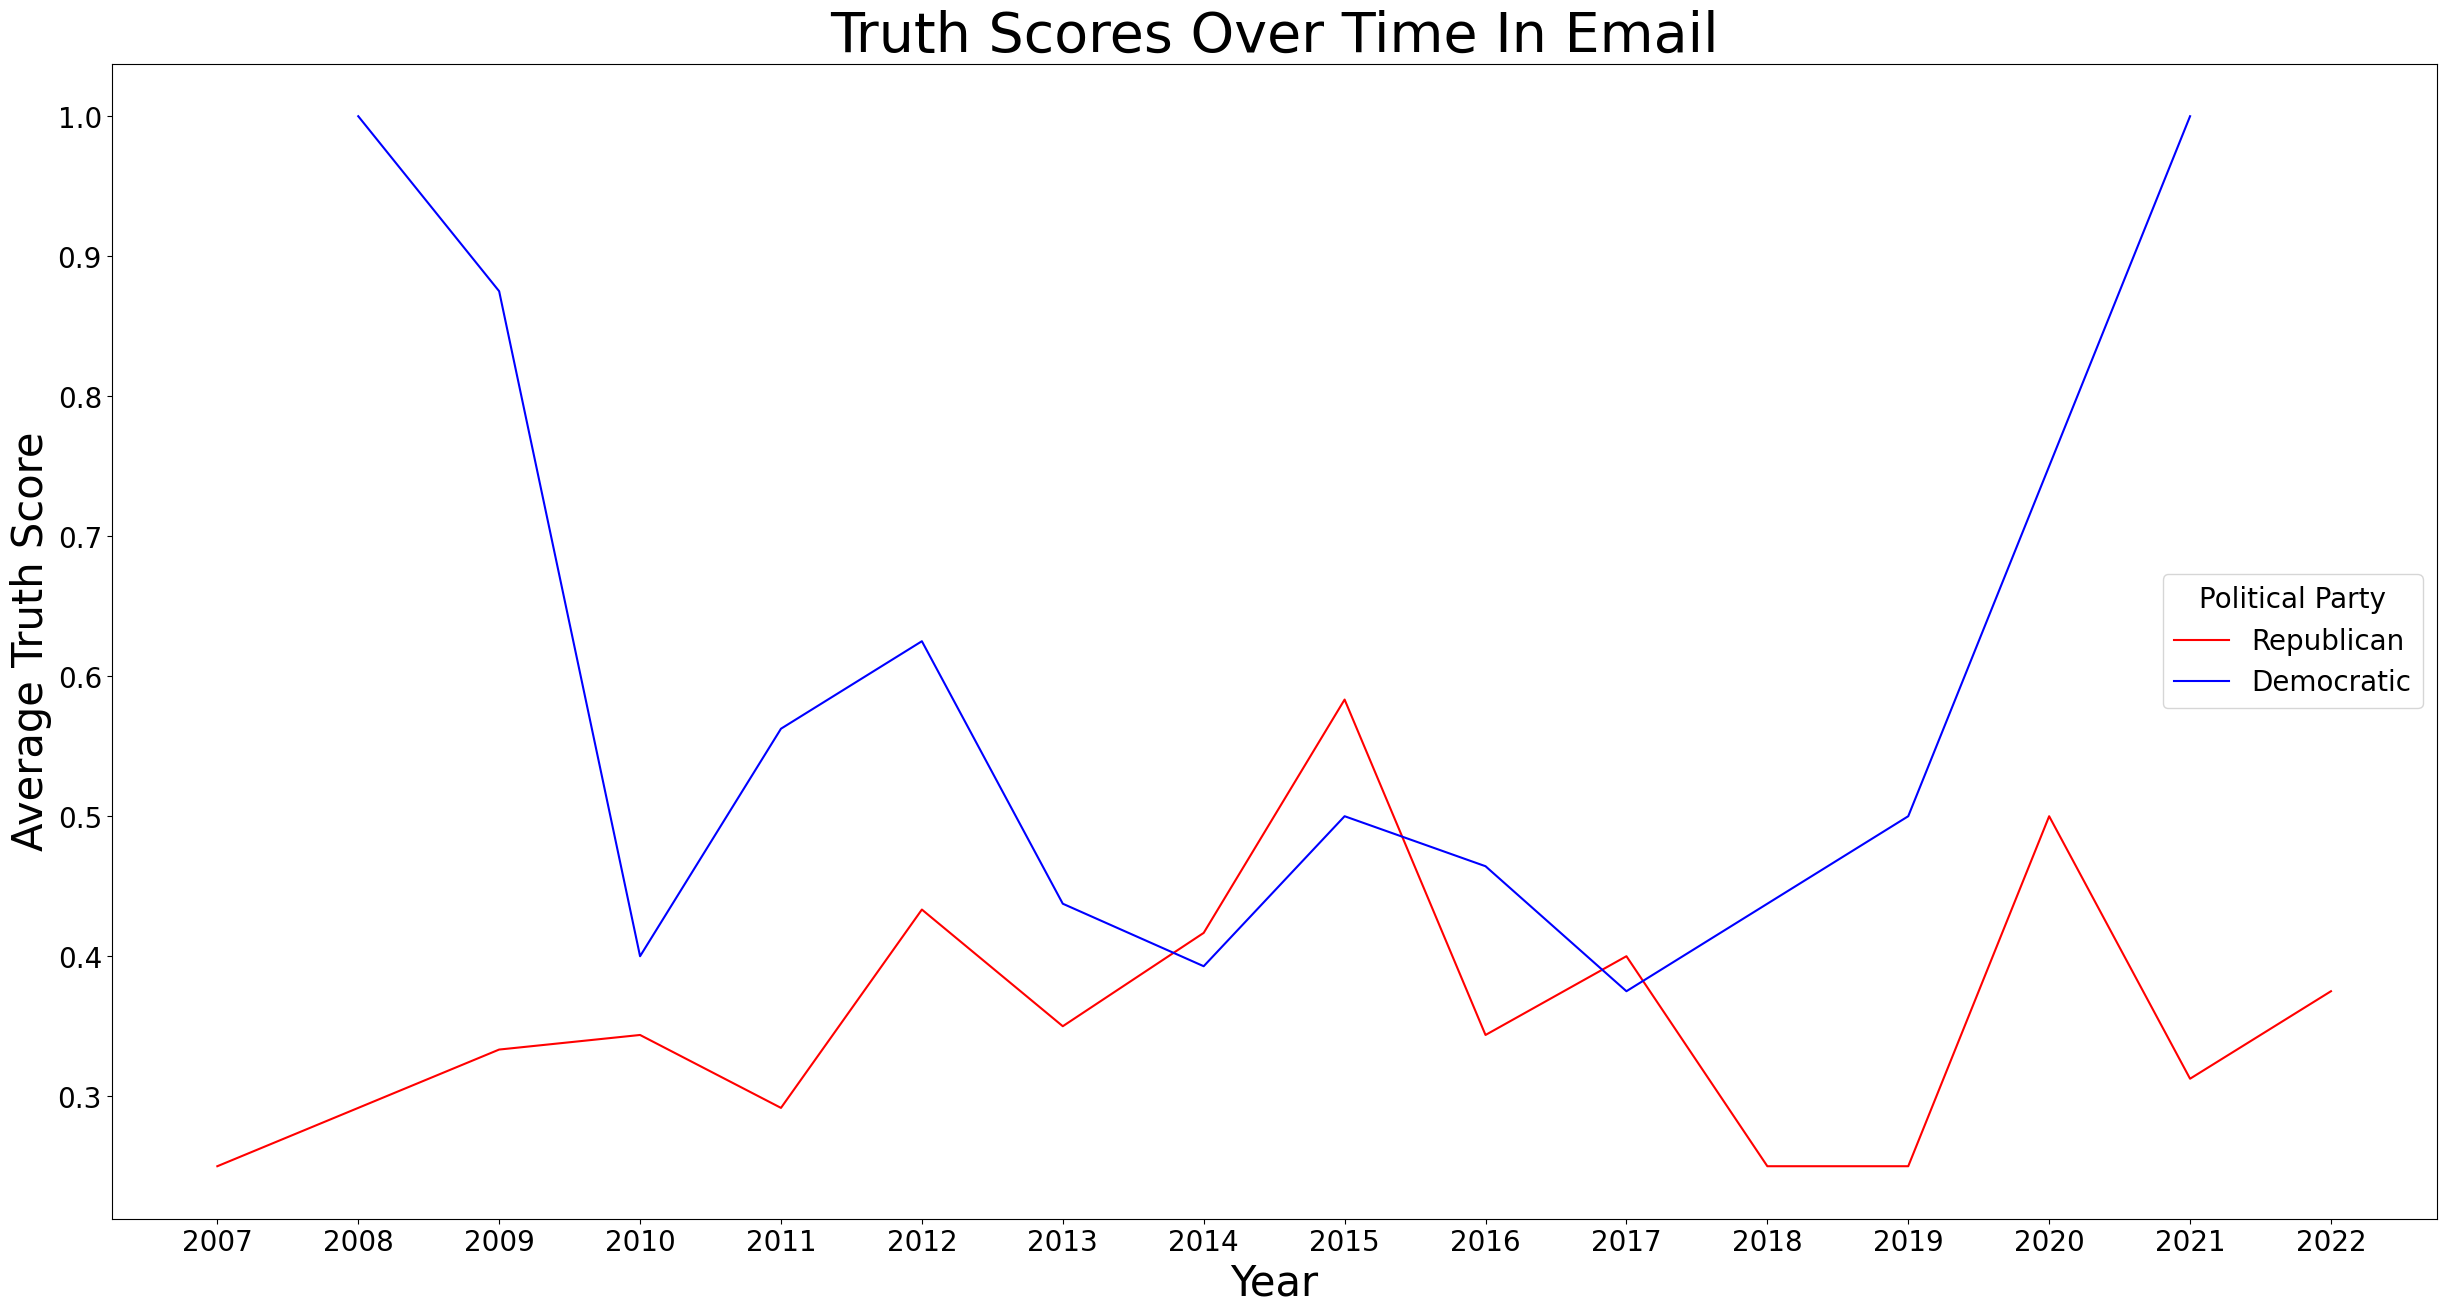

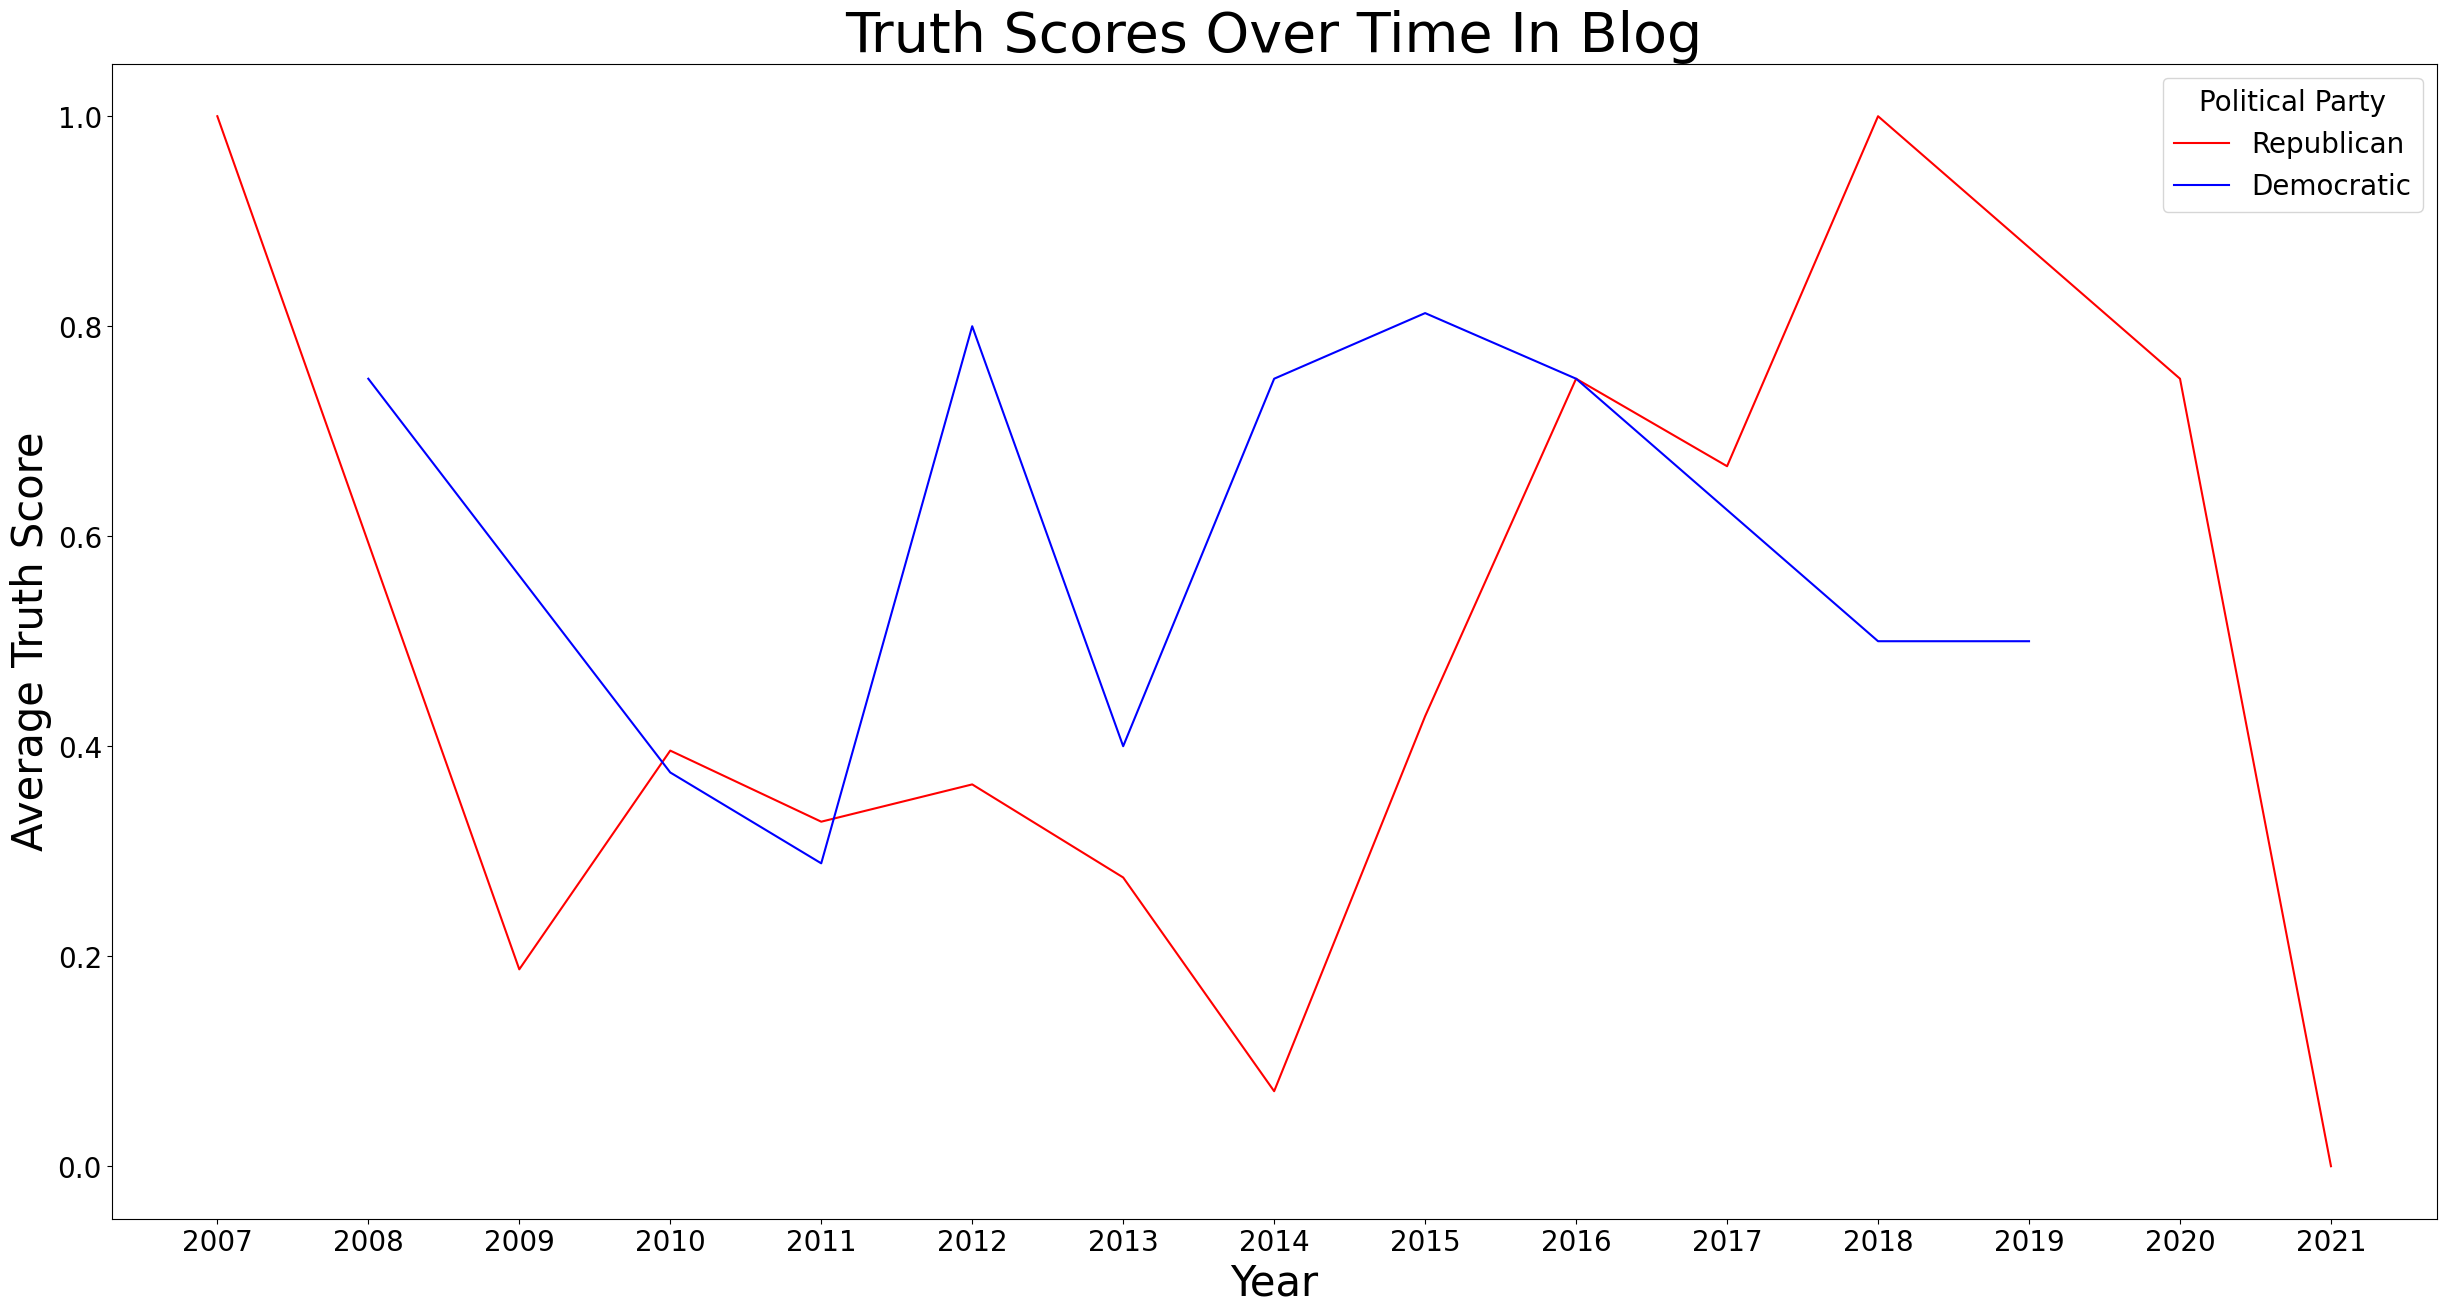

In [23]:
sources = df['statement_source'].unique()
for i in range(len(sources)):
    fig, ax = plt.subplots(figsize=(30, 15))
    sns.lineplot(data=df_source[df_source['statement_source'] == sources[i]], x='statement_year', y='avg_verdict_score', 
                 hue='party_affiliation_refined', palette={'Democratic': 'blue', 'Republican': 'red'})
    
    ax.set_title(f'Truth Scores Over Time In {sources[i].capitalize()}', fontsize = 40)
    ax.set_ylabel('Average Truth Score', fontsize=30)
    ax.set_xlabel('Year', fontsize=30)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(title='Political Party', title_fontsize=20, fontsize=20)

    plt.show()

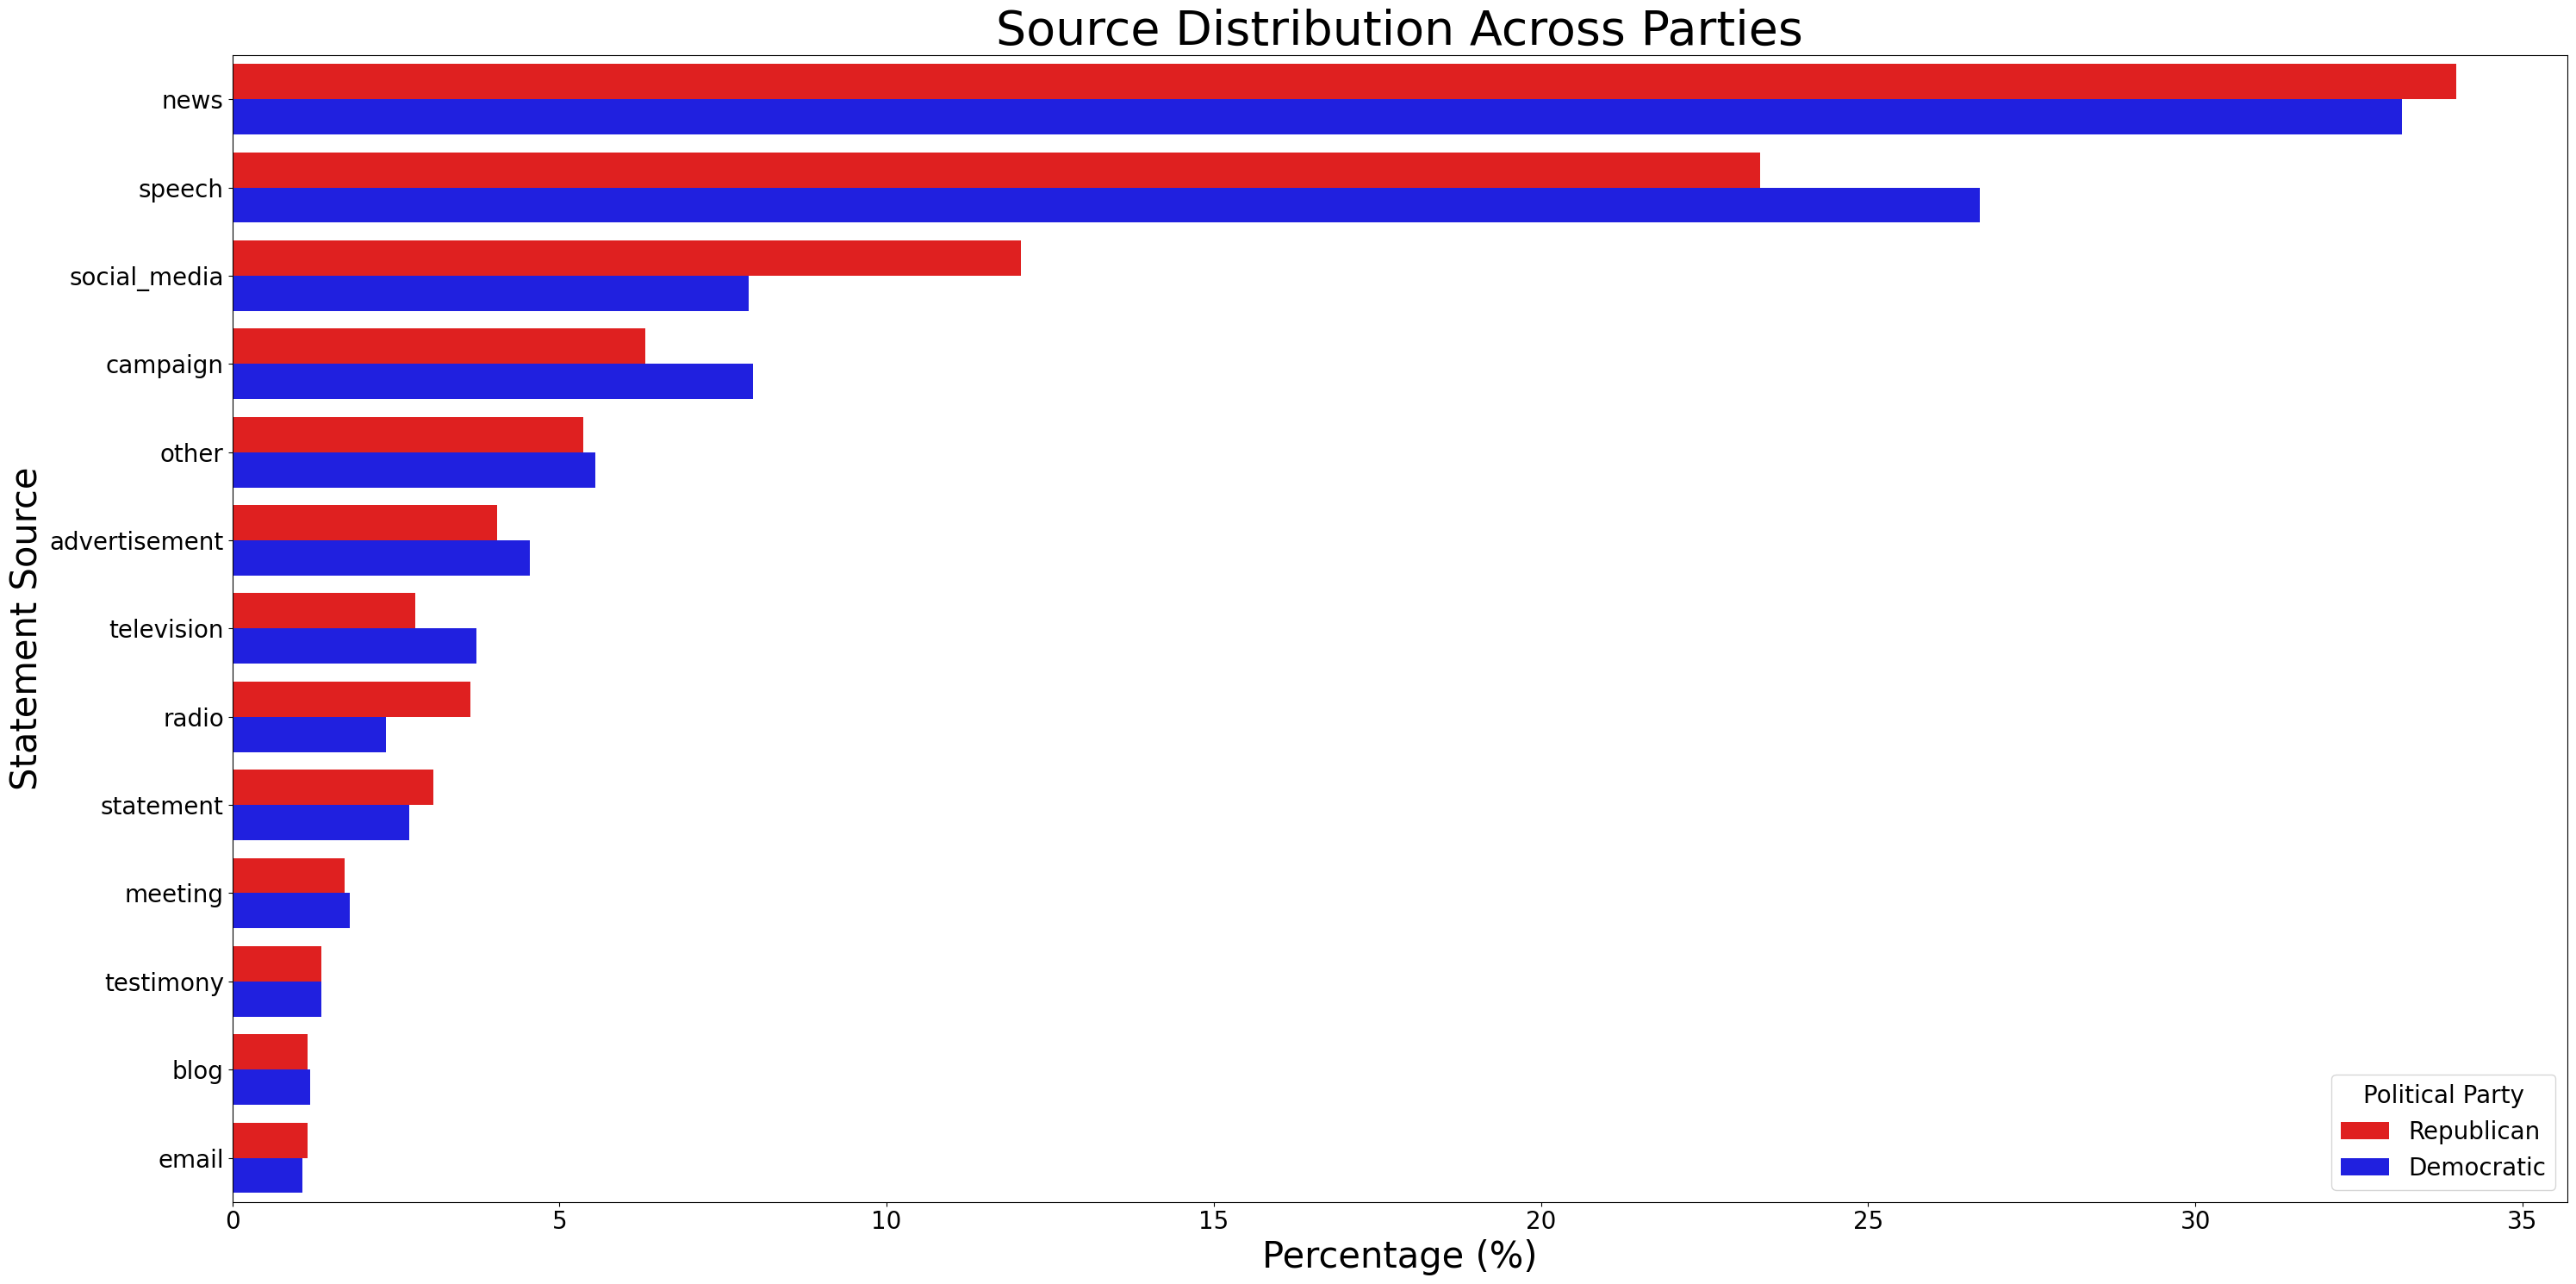

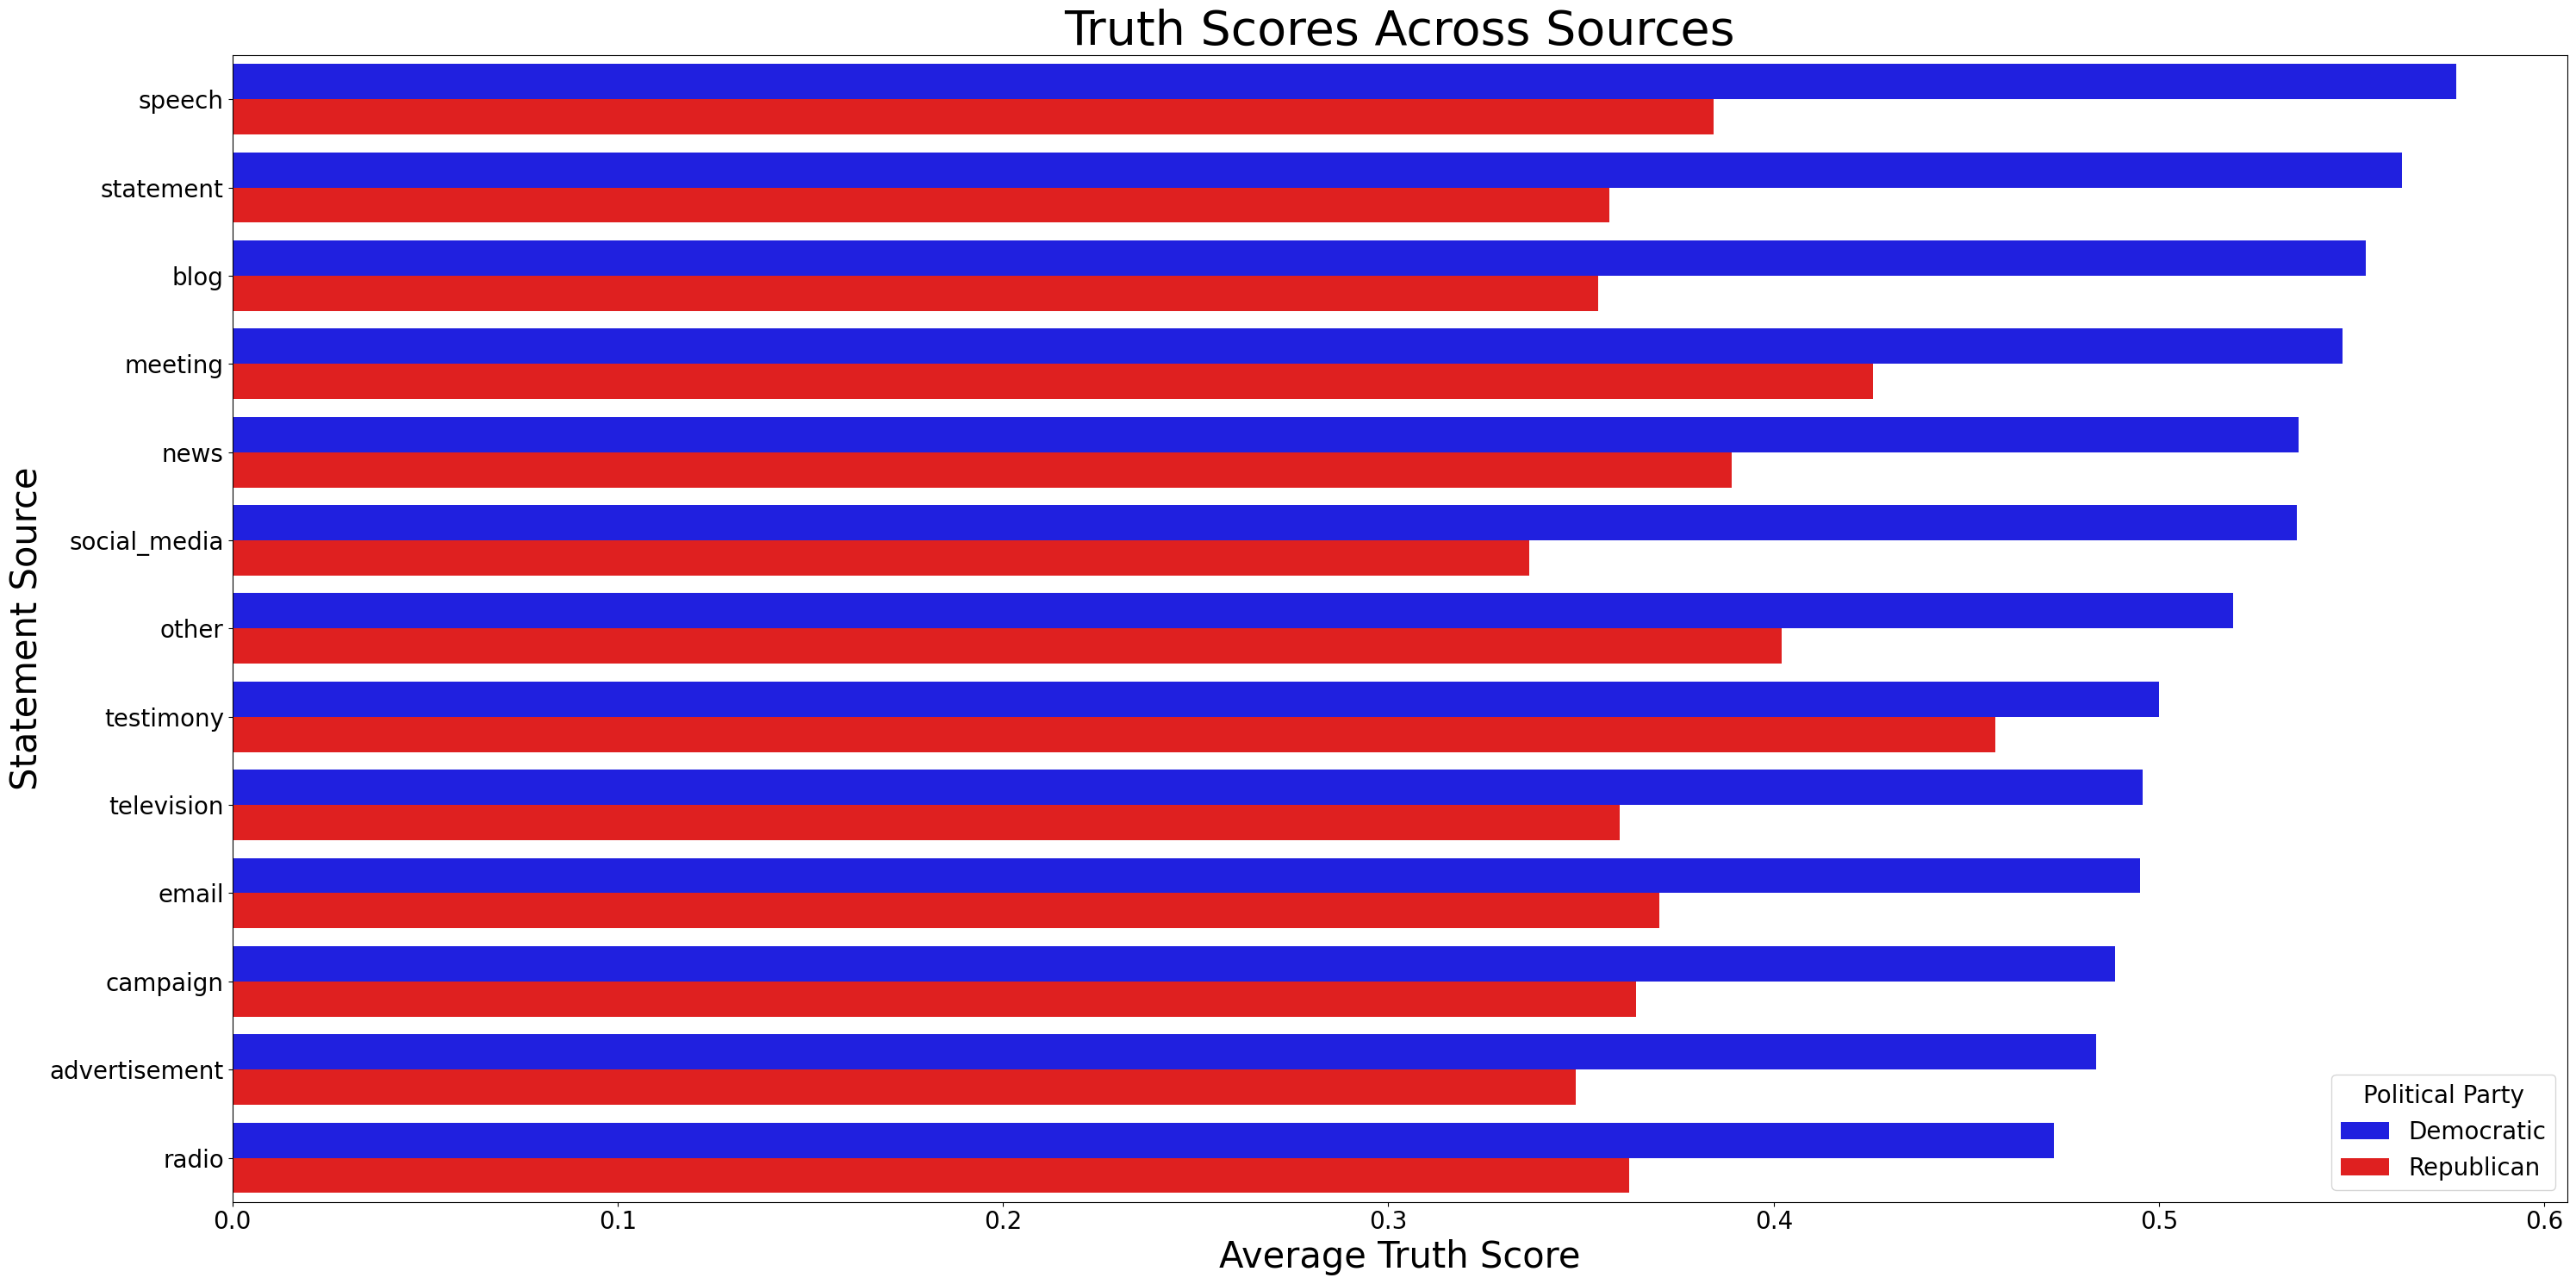

Democratic Average Truth Score Standard Deviation: 0.03242201224774964
Republican Average Truth Score Standard Deviation: 0.03246907467506375


In [25]:
#Count
count = df.groupby(['statement_source', 'party_affiliation_refined'])[['verdict']].count()
count = count.rename(columns={'verdict': 'count'})
count = count.reset_index()

party_totals = count.groupby('party_affiliation_refined')['count'].transform('sum')
count['percentage'] = (count['count'] / party_totals) * 100
count = count.sort_values(by='percentage', ascending=False)

fig, ax = plt.subplots(figsize=(30, 15))
sns.barplot(data=count,
            x='percentage',
            y='statement_source',
            hue ='party_affiliation_refined',
            palette={'Democratic': 'blue', 'Republican': 'red'})

ax.set_title('Source Distribution Across Parties', fontsize=40)
ax.set_ylabel('Statement Source', fontsize=30)
ax.set_xlabel('Percentage (%)', fontsize=30)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(title='Political Party', fontsize=20, title_fontsize=20)
plt.tight_layout()
plt.show()

#Average
avg = df.groupby(['statement_source', 'party_affiliation_refined'])[['verdict_score']].mean()
avg = avg.rename(columns={'verdict_score': 'avg_verdict_score'})
avg = avg.reset_index()
avg = avg.sort_values(by='avg_verdict_score', ascending=False)

fig, ax = plt.subplots(figsize=(30, 15))
sns.barplot(data=avg,
            x='avg_verdict_score',
            y='statement_source',
            hue ='party_affiliation_refined',
            palette={'Democratic': 'blue', 'Republican': 'red'})

ax.set_title('Truth Scores Across Sources', fontsize=40)
ax.set_ylabel('Statement Source', fontsize=30)
ax.set_xlabel('Average Truth Score', fontsize=30)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(title='Political Party', fontsize=20, title_fontsize=20)
plt.tight_layout()
plt.show()

democratic_std = np.std(avg[avg['party_affiliation_refined'] == 'Democratic']['avg_verdict_score'])
republican_std = np.std(avg[avg['party_affiliation_refined'] == 'Republican']['avg_verdict_score'])

print(f'Democratic Average Truth Score Standard Deviation: {democratic_std}')
print(f'Republican Average Truth Score Standard Deviation: {republican_std}')

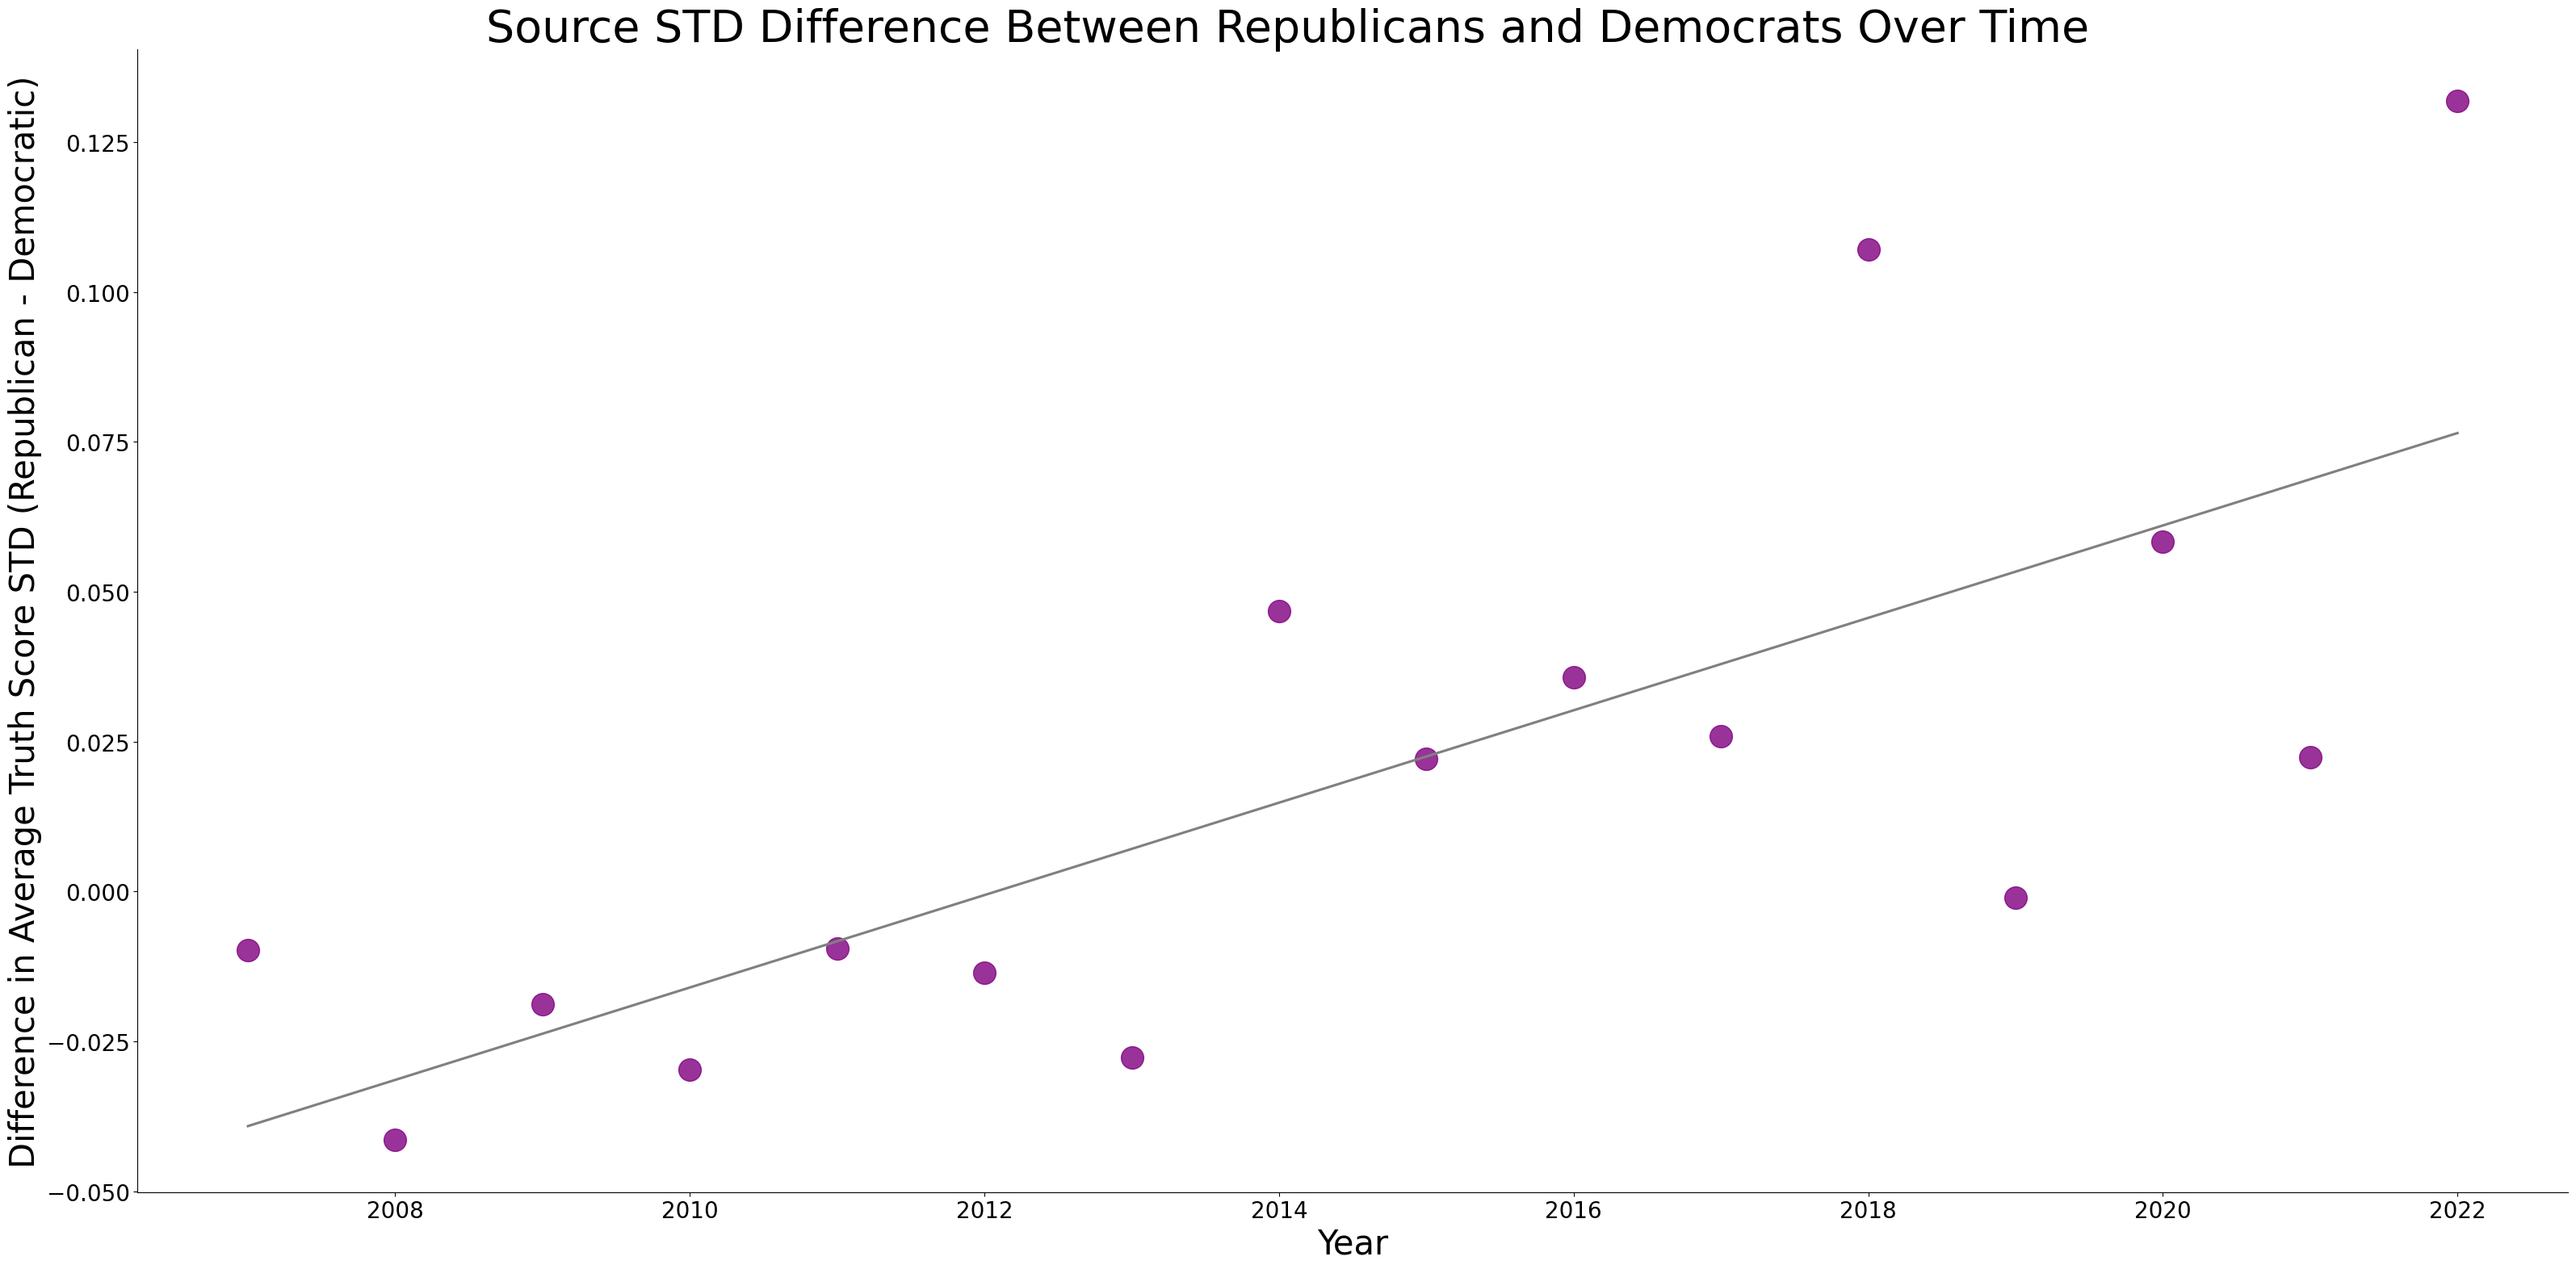

In [245]:
diffs = []
years = []
for year in sorted(df['statement_year'].unique()):
    avg = df[df['statement_year'] == year]
    avg = avg.groupby(['statement_source', 'party_affiliation_refined'])[['verdict_score']].mean()
    avg = avg.rename(columns={'verdict_score': 'avg_verdict_score'})
    avg = avg.reset_index()
    avg = avg.sort_values(by='avg_verdict_score', ascending=False)

    democratic_std = np.std(avg[avg['party_affiliation_refined'] == 'Democratic']['avg_verdict_score'])
    republican_std = np.std(avg[avg['party_affiliation_refined'] == 'Republican']['avg_verdict_score'])

    years.append(float(year))
    diff = republican_std - democratic_std
    diffs.append(diff)

diff_df = pd.DataFrame({'Year': years,
                        'Score_Diff': diffs})

g = sns.lmplot(
    data=diff_df,
    x='Year',
    y='Score_Diff',
    height=16,
    aspect=2,
    ci=None,
    line_kws={'color': 'gray'},
    scatter_kws={'s': 400, 'color': 'purple'}
)

g.fig.suptitle("Source STD Difference Between Republicans and Democrats Over Time", fontsize=40)
g.set_axis_labels("Year", "Difference in Average Truth Score STD (Republican - Democratic)", fontsize=30)
g.ax.tick_params(axis='x', labelsize=20)  
g.ax.tick_params(axis='y', labelsize=20)  
plt.tight_layout()
plt.show()

# Statistical Tests

## Permutation Test

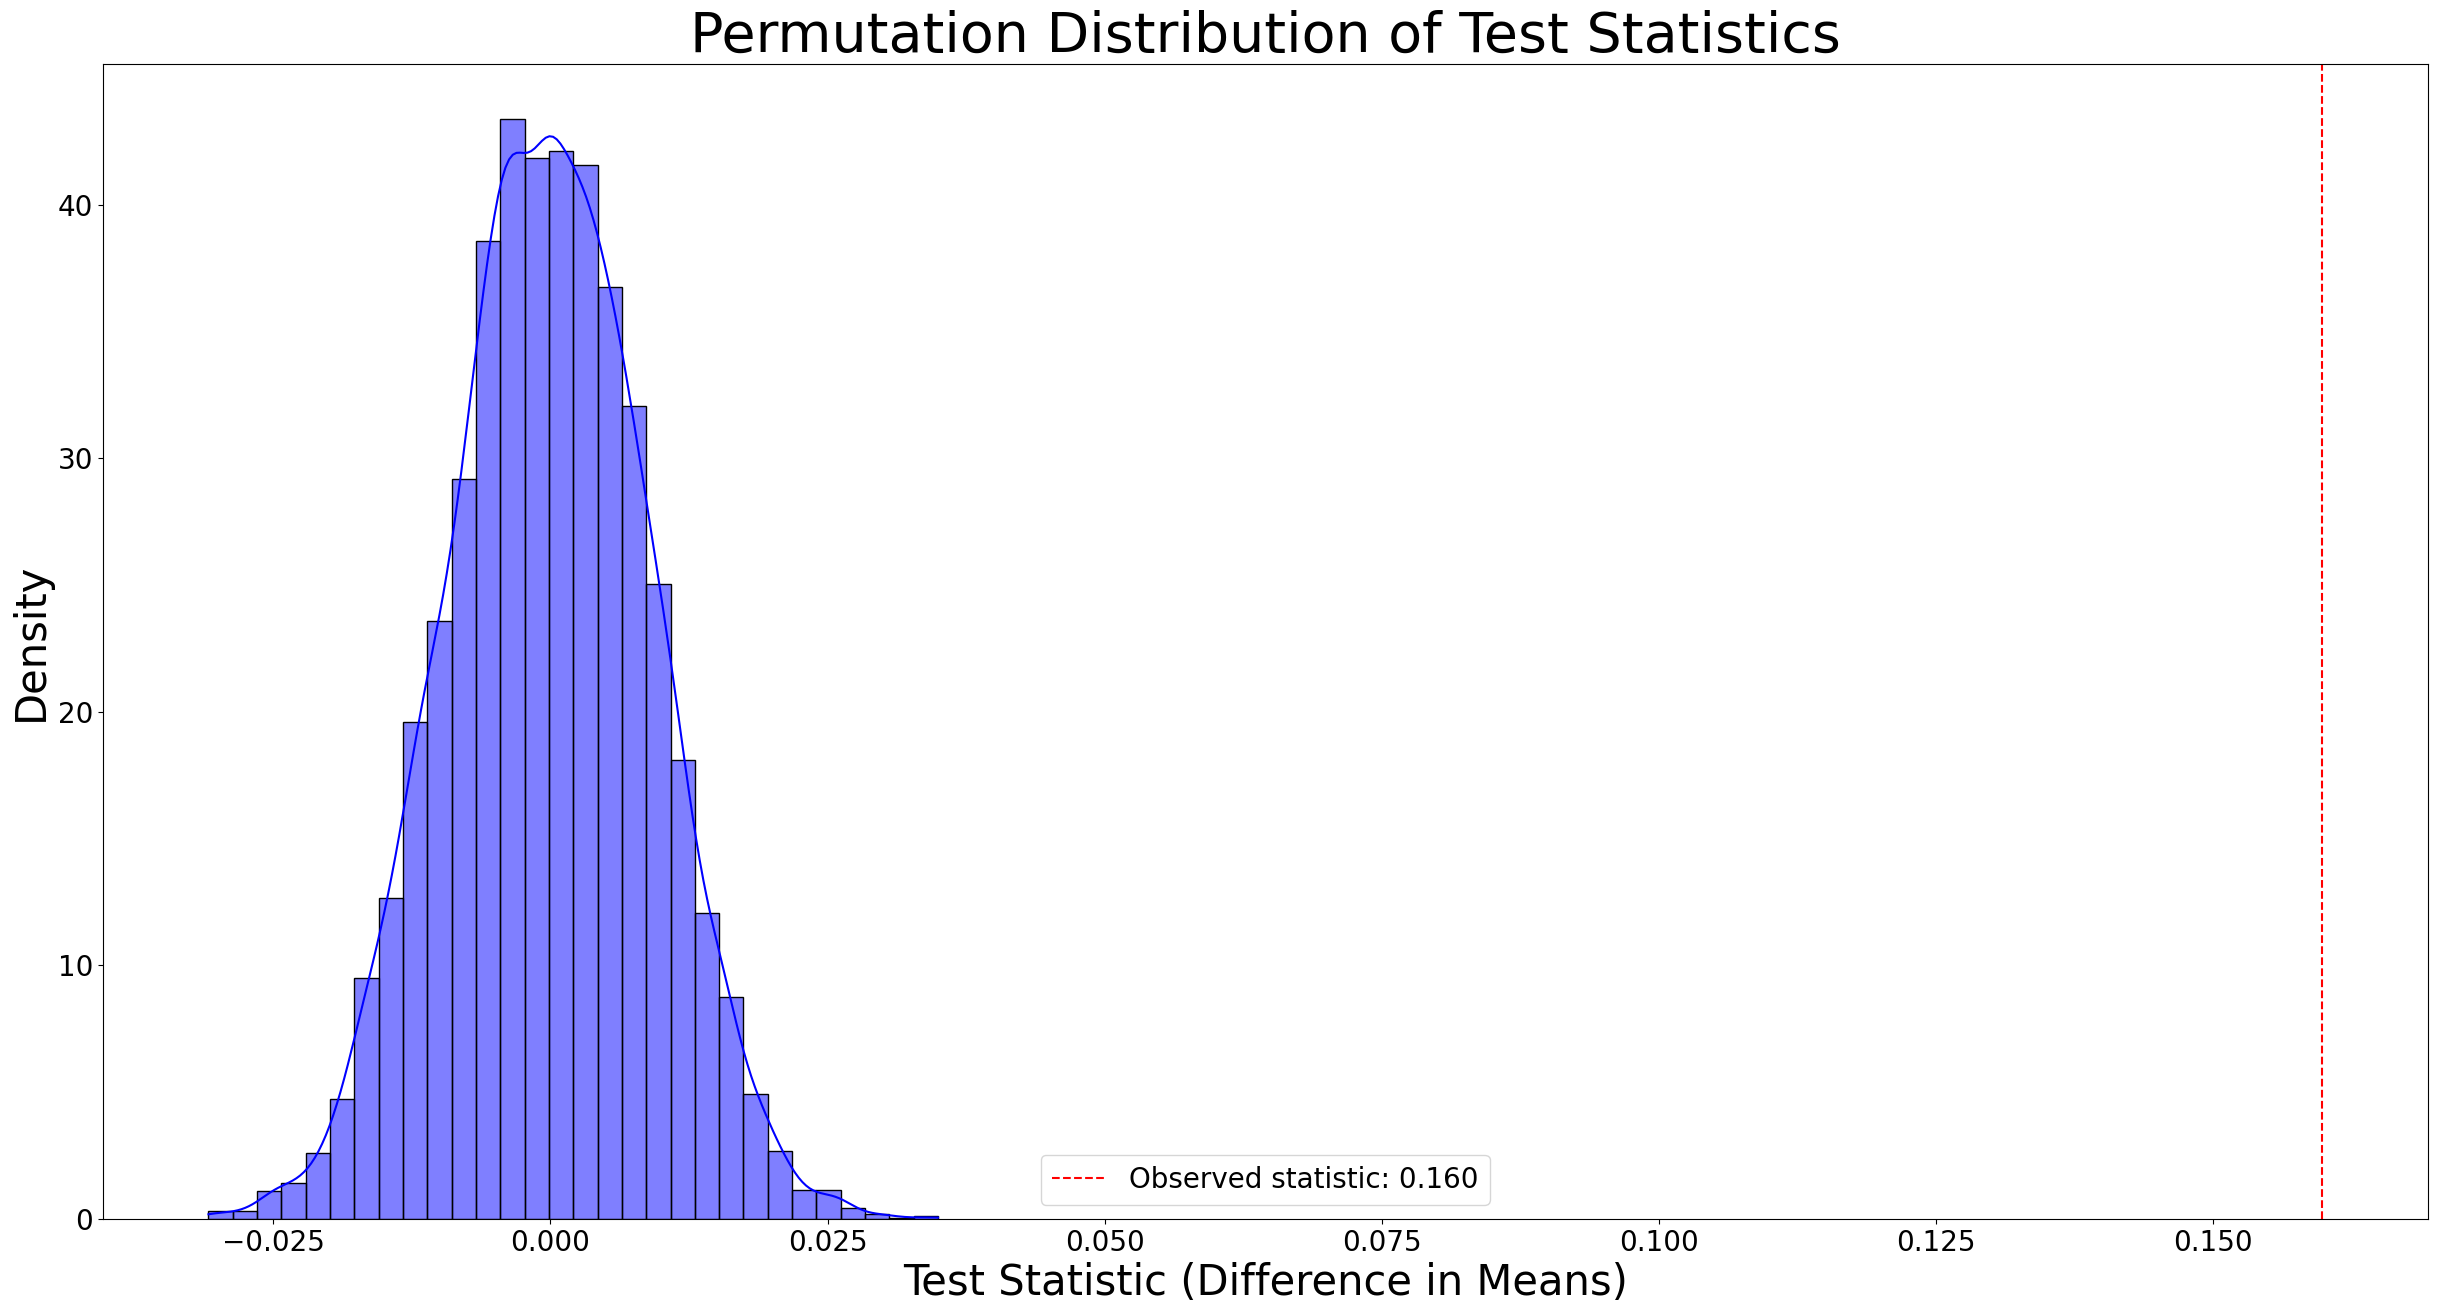

Observed statistic (parameter): 0.160
P-value: 0.0000


In [27]:
parameter = df[df['party_affiliation_refined'] == 'Democratic']['verdict_score'].mean() - \
            df[df['party_affiliation_refined'] == 'Republican']['verdict_score'].mean()

statistics = []
for i in range(10000):
    shuffled = df.copy()
    shuffled['party_shuffled'] = df['party_affiliation_refined'].sample(frac=1).reset_index(drop=True)
    statistic = shuffled[shuffled['party_shuffled'] == 'Democratic']['verdict_score'].mean() - \
                shuffled[shuffled['party_shuffled'] == 'Republican']['verdict_score'].mean()
    statistics.append(statistic)

p_value = np.mean(statistics >= parameter)

plt.figure(figsize=(30, 15))
sns.histplot(statistics, kde=True, color='blue', bins=30, stat='density')
plt.axvline(x=parameter, color='red', linestyle='--', label=f'Observed statistic: {parameter:.3f}')
plt.title('Permutation Distribution of Test Statistics', fontsize=40)
plt.xlabel('Test Statistic (Difference in Means)', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=20)
plt.show()

print(f"Observed statistic (parameter): {parameter:.3f}")
print(f"P-value: {p_value:.4f}")

**Null Hypothesis (H₀):**  
  Democrats have the same average truth score compared to Republicans.
  
**Alternative Hypothesis (H₁):**  
  Democrats have a higher average truth score compared to Republicans.
  
**Results:**  
  Reject the null hypothesis and support the alternative hypothesis because the p-value is less than 0.05.

## Chi-squared Test

In [264]:
features = ['statement_originator', 'statement', 'statement_date', 'statement_source', \
            'factchecker', 'factcheck_date', 'factcheck_analysis_link', 'party_affiliation_refined', \
            'statement_year']
rows = []
for feature in features:
    table = pd.crosstab(df[feature], df['verdict'])
    chi2, p, dof, _ = chi2_contingency(table)
    row = [feature, f"{chi2:.3f}", f"{p:.4f}", f"{dof}"]
    rows.append(row)
    
chi_results = pd.DataFrame(rows, columns = ['Feature', 'Chi2', 'P-value', 'DOF'])
chi_results = chi_results.set_index('Feature')
chi_results

,Chi2,P-value,DOF
Feature,,,
statement_originator,11148.838,0.0000,9325
statement,57910.001,0.4699,57885
statement_date,20869.516,0.0002,20150
statement_source,159.049,0.0000,60
factchecker,3200.296,0.0000,2375
factcheck_date,20146.446,0.0039,19615
factcheck_analysis_link,57915.000,0.4934,57910
party_affiliation_refined,639.615,0.0000,5
statement_year,466.074,0.0000,80


**Null Hypothesis (H₀):**  
  There is an independent relationship between the feature and the verdict.

**Alternative Hypothesis (H₁):**  
  There is an dependent relationship between the feature and the verdict.

**Results:**  
  Since the p-values are less than 0.05 for the features statement_originator, statement_date, statement_source, factchecker, 
  factcheck_date, party_affiliation_refined, and statement_year, reject the null hypothesis and support the alternative hypothesis for each 
  of the listed features.

## ANOVA

In [29]:
# Source
model_source = smf.ols('verdict_score ~ C(statement_source)', data=df).fit()
anova_source = sm.stats.anova_lm(model_source, typ=2)

# Party
model_party = smf.ols('verdict_score ~ C(party_affiliation_refined)', data=df).fit()
anova_party = sm.stats.anova_lm(model_party, typ=2)

# Year
model_year = smf.ols('verdict_score ~ C(statement_year)', data=df).fit()
anova_year = sm.stats.anova_lm(model_year, typ=2)

p_val_source = anova_source["PR(>F)"][0]
p_val_party = anova_party["PR(>F)"][0]
p_val_year = anova_year["PR(>F)"][0]

print(f"P-value (Source): {p_val_source}")
print(f"P-value (Party): {p_val_party}")
print(f"P-value (Year): {p_val_year}")

P-value (Source): 2.0711877743015573e-07
P-value (Party): 6.342165253147885e-129
P-value (Year): 1.1035056534844225e-49


/var/folders/k7/8ggfb7gd3kl0x8_3d3gh_cb40000gn/T/ipykernel_4312/2856895931.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val_source = anova_source["PR(>F)"][0]
/var/folders/k7/8ggfb7gd3kl0x8_3d3gh_cb40000gn/T/ipykernel_4312/2856895931.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val_party = anova_party["PR(>F)"][0]
/var/folders/k7/8ggfb7gd3kl0x8_3d3gh_cb40000gn/T/ipykernel_4312/2856895931.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

**Null Hypothesis (H₀):**  
  All group means are equal.

**Alternative Hypothesis (H₁):**  
  At least one group mean is different.

**Results:**  
  Since the p-values are less than 0.05 for the features statement_source, party_affiliation_refined, and statement_year, reject the null 
  hypothesis and support the alternative hypothesis for these features.